# Bitcoin Price Prediction Using Machine Learning Algorithams #

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
import plotly.express as px
import hashlib
sns.set(style='darkgrid')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

# Functions

FUNCTION FOR FILLING MISSING DATA IN THE DATAFRAME

In [24]:
def fill_missing(df):
    ### function to impute missing values using interpolation ###
    df['Open'] = df['Open'].interpolate()
    df['Close'] = df['Close'].interpolate()
    df['Weighted_Price'] = df['Weighted_Price'].interpolate()

    df['Volume_(BTC)'] = df['Volume_(BTC)'].interpolate()
    df['Volume_(Currency)'] = df['Volume_(Currency)'].interpolate()
    df['High'] = df['High'].interpolate()
    df['Low'] = df['Low'].interpolate()

    print(df.head())
    print(df.isnull().sum())
    return df

DICKEY-FULLER TEST FUNCTION

In [25]:
def adf_test(df):
    series = df.Weighted_Price
    stats, p, lags, critical_values = kpss(series, 'ct')
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(series, autolag='AIC')
    print("dftest: ", dftest)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
    if p > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary\n\n')

MAE & RMSE SCORE FUNCTION

In [26]:
def mae_rmse_score(org, pred):
    mae = round(mean_absolute_error(org, pred),2)
    rmse = round(np.sqrt(mean_squared_error(org, pred)),2)
    return mae, rmse

MAPE SCORE FUNCTION

In [27]:
def mape_score(org,pred):
    mape = round(np.mean(np.abs((org - pred)/org))*100, 2)
    return mape

CONVERTING THE CSV FILE TO DATAFRAME AND SHOWING THE DATAFRAME AND ITS INFORMATION 


In [28]:
BTC_DF = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")

print('~Information~\n--------------------------------------------------------------')
BTC_DF.info()
print()
print('~Dataframe~\n--------------------------------------------------------------')
BTC_DF.head()

~Information~
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB

~Dataframe~
--------------------------------------------------------------


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CONVERTING TIMESTAMP COLUMN FROM STRING TO DATETIME

In [29]:
BTC_DF['Timestamp'] = [datetime.fromtimestamp(x) for x in BTC_DF['Timestamp']]
BTC_DF.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 13:22:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,2011-12-31 13:23:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 13:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 13:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 13:26:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


BITCOIN WEIGHTED PRICE PLOT WITH NOISE

<Axes: title={'center': 'Bitcoin Weighted Price'}>

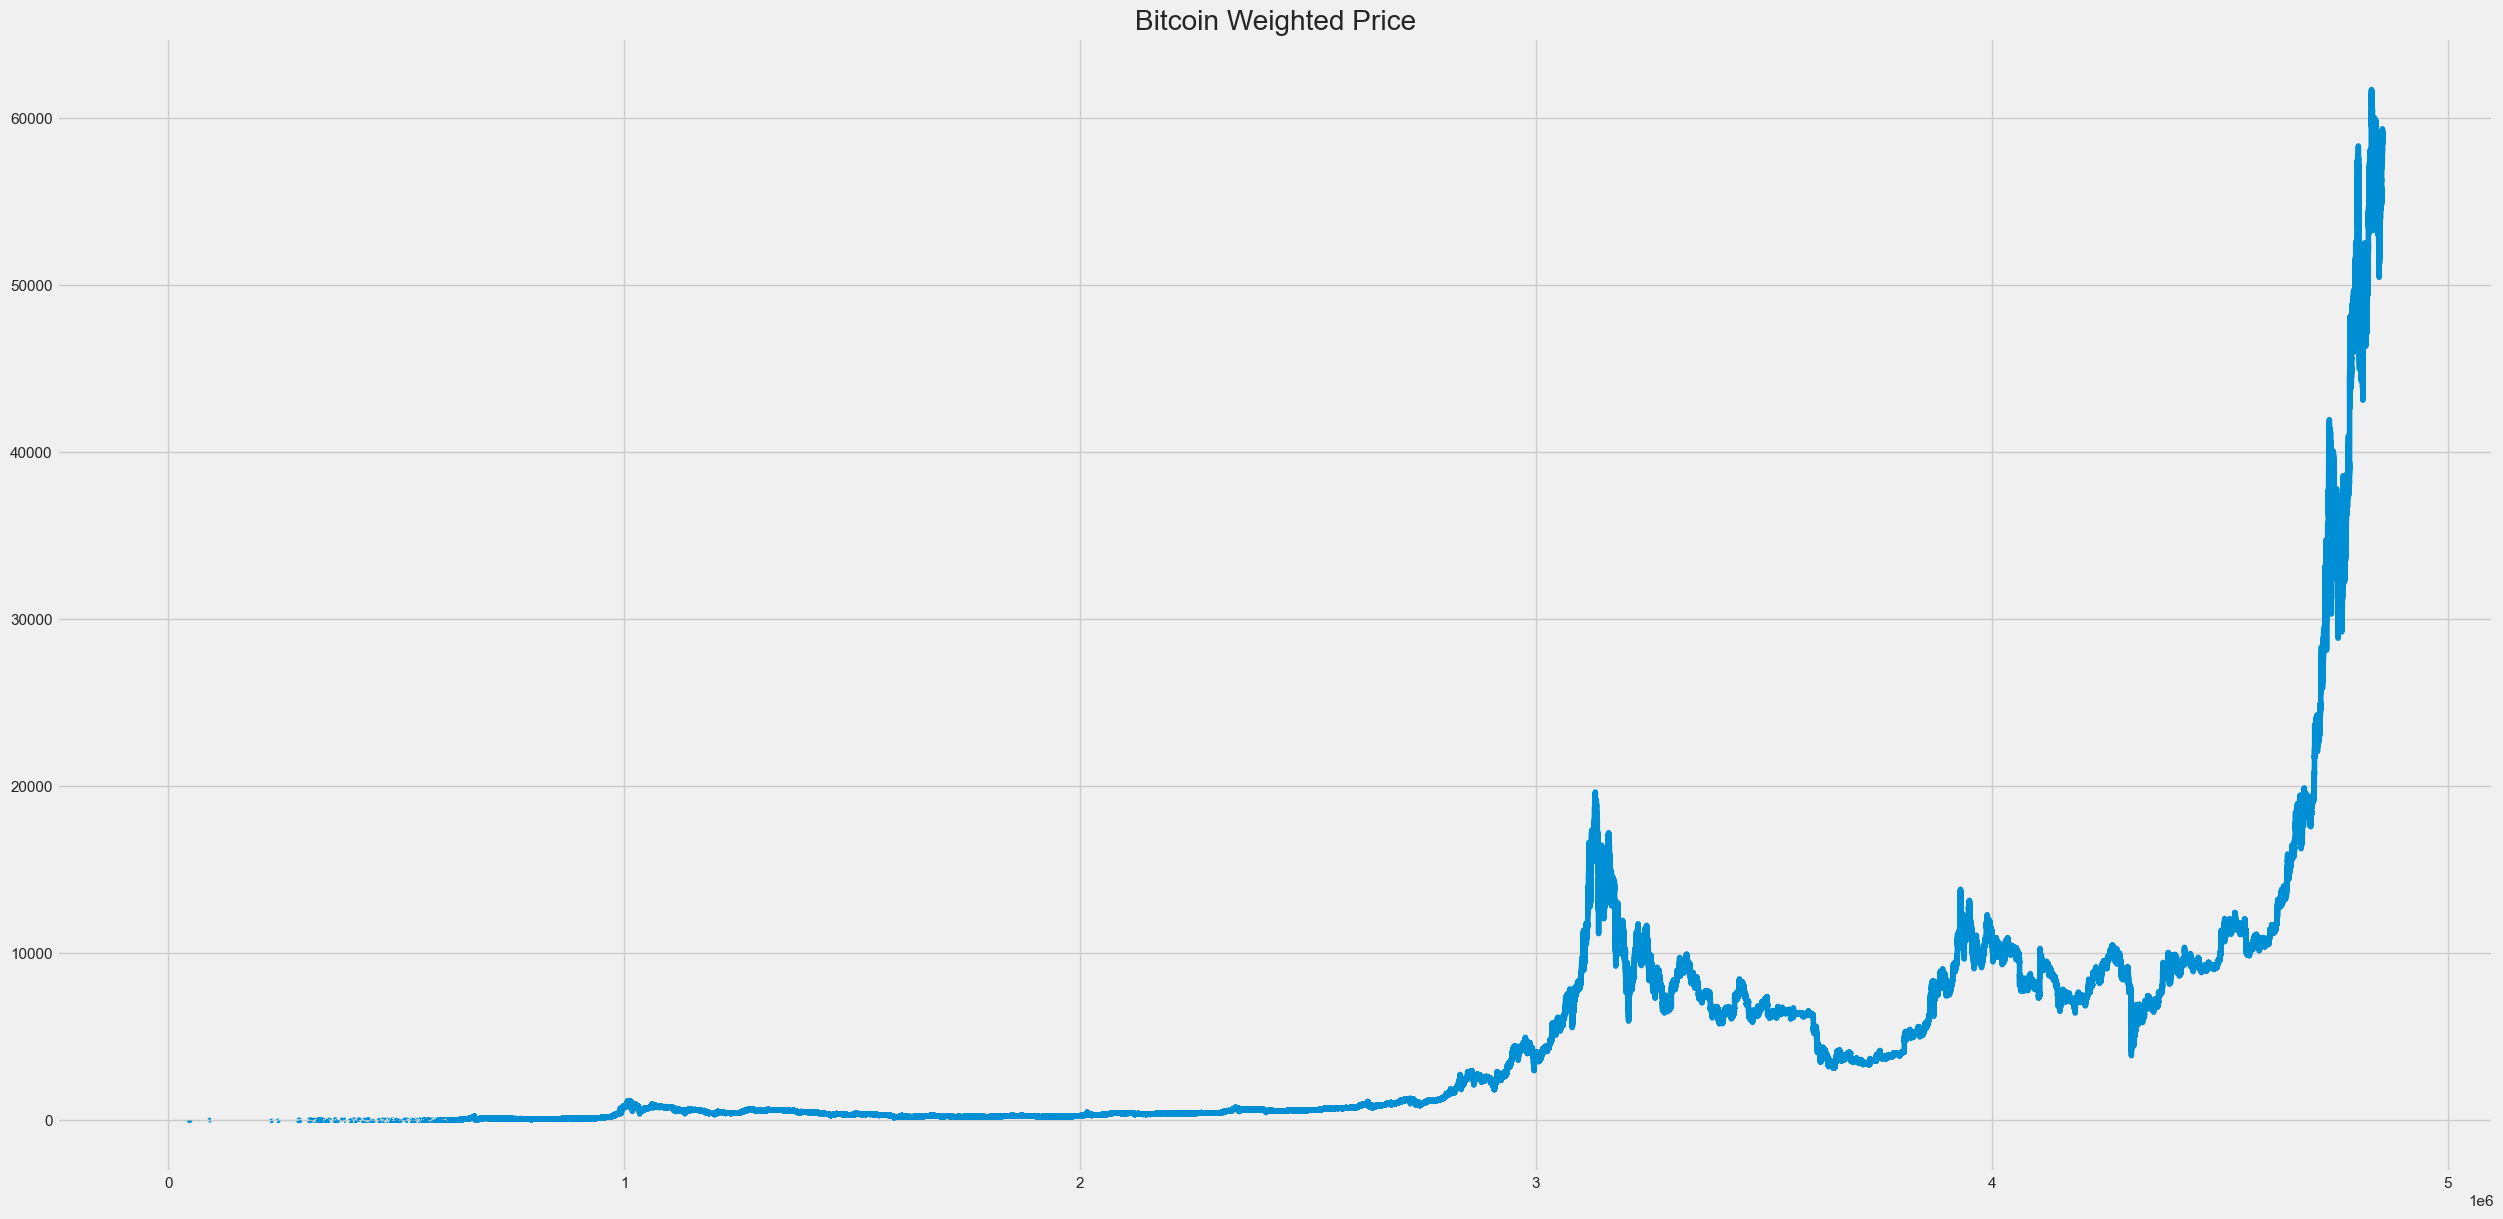

In [30]:
BTC_DF.Weighted_Price.plot(figsize=(28,14), title="Bitcoin Weighted Price")

CALCULATING MISSING VALUES IN THE DATASET

In [31]:
missing_values = BTC_DF.isnull().sum()
missing_per = (missing_values/BTC_DF.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Timestamp,0,0.00000
Open,1243608,25.60246
High,1243608,25.60246
Low,1243608,25.60246
Close,1243608,25.60246
Volume_(BTC),1243608,25.60246
Volume_(Currency),1243608,25.60246
Weighted_Price,1243608,25.60246


BITCOIN WEIGHTED PRICE PLOT AFTER REMOVING NOISE FROM DATA

            Timestamp  Open  High   Low  Close  Volume_(BTC)  \
0 2011-12-31 13:22:00  4.39  4.39  4.39   4.39      0.455581   
1 2011-12-31 13:23:00  4.39  4.39  4.39   4.39      0.555046   
2 2011-12-31 13:24:00  4.39  4.39  4.39   4.39      0.654511   
3 2011-12-31 13:25:00  4.39  4.39  4.39   4.39      0.753977   
4 2011-12-31 13:26:00  4.39  4.39  4.39   4.39      0.853442   

   Volume_(Currency)  Weighted_Price  
0           2.000000            4.39  
1           2.436653            4.39  
2           2.873305            4.39  
3           3.309958            4.39  
4           3.746611            4.39  
Timestamp            0
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


<Axes: title={'center': 'Bitcoin Weighted Price'}>

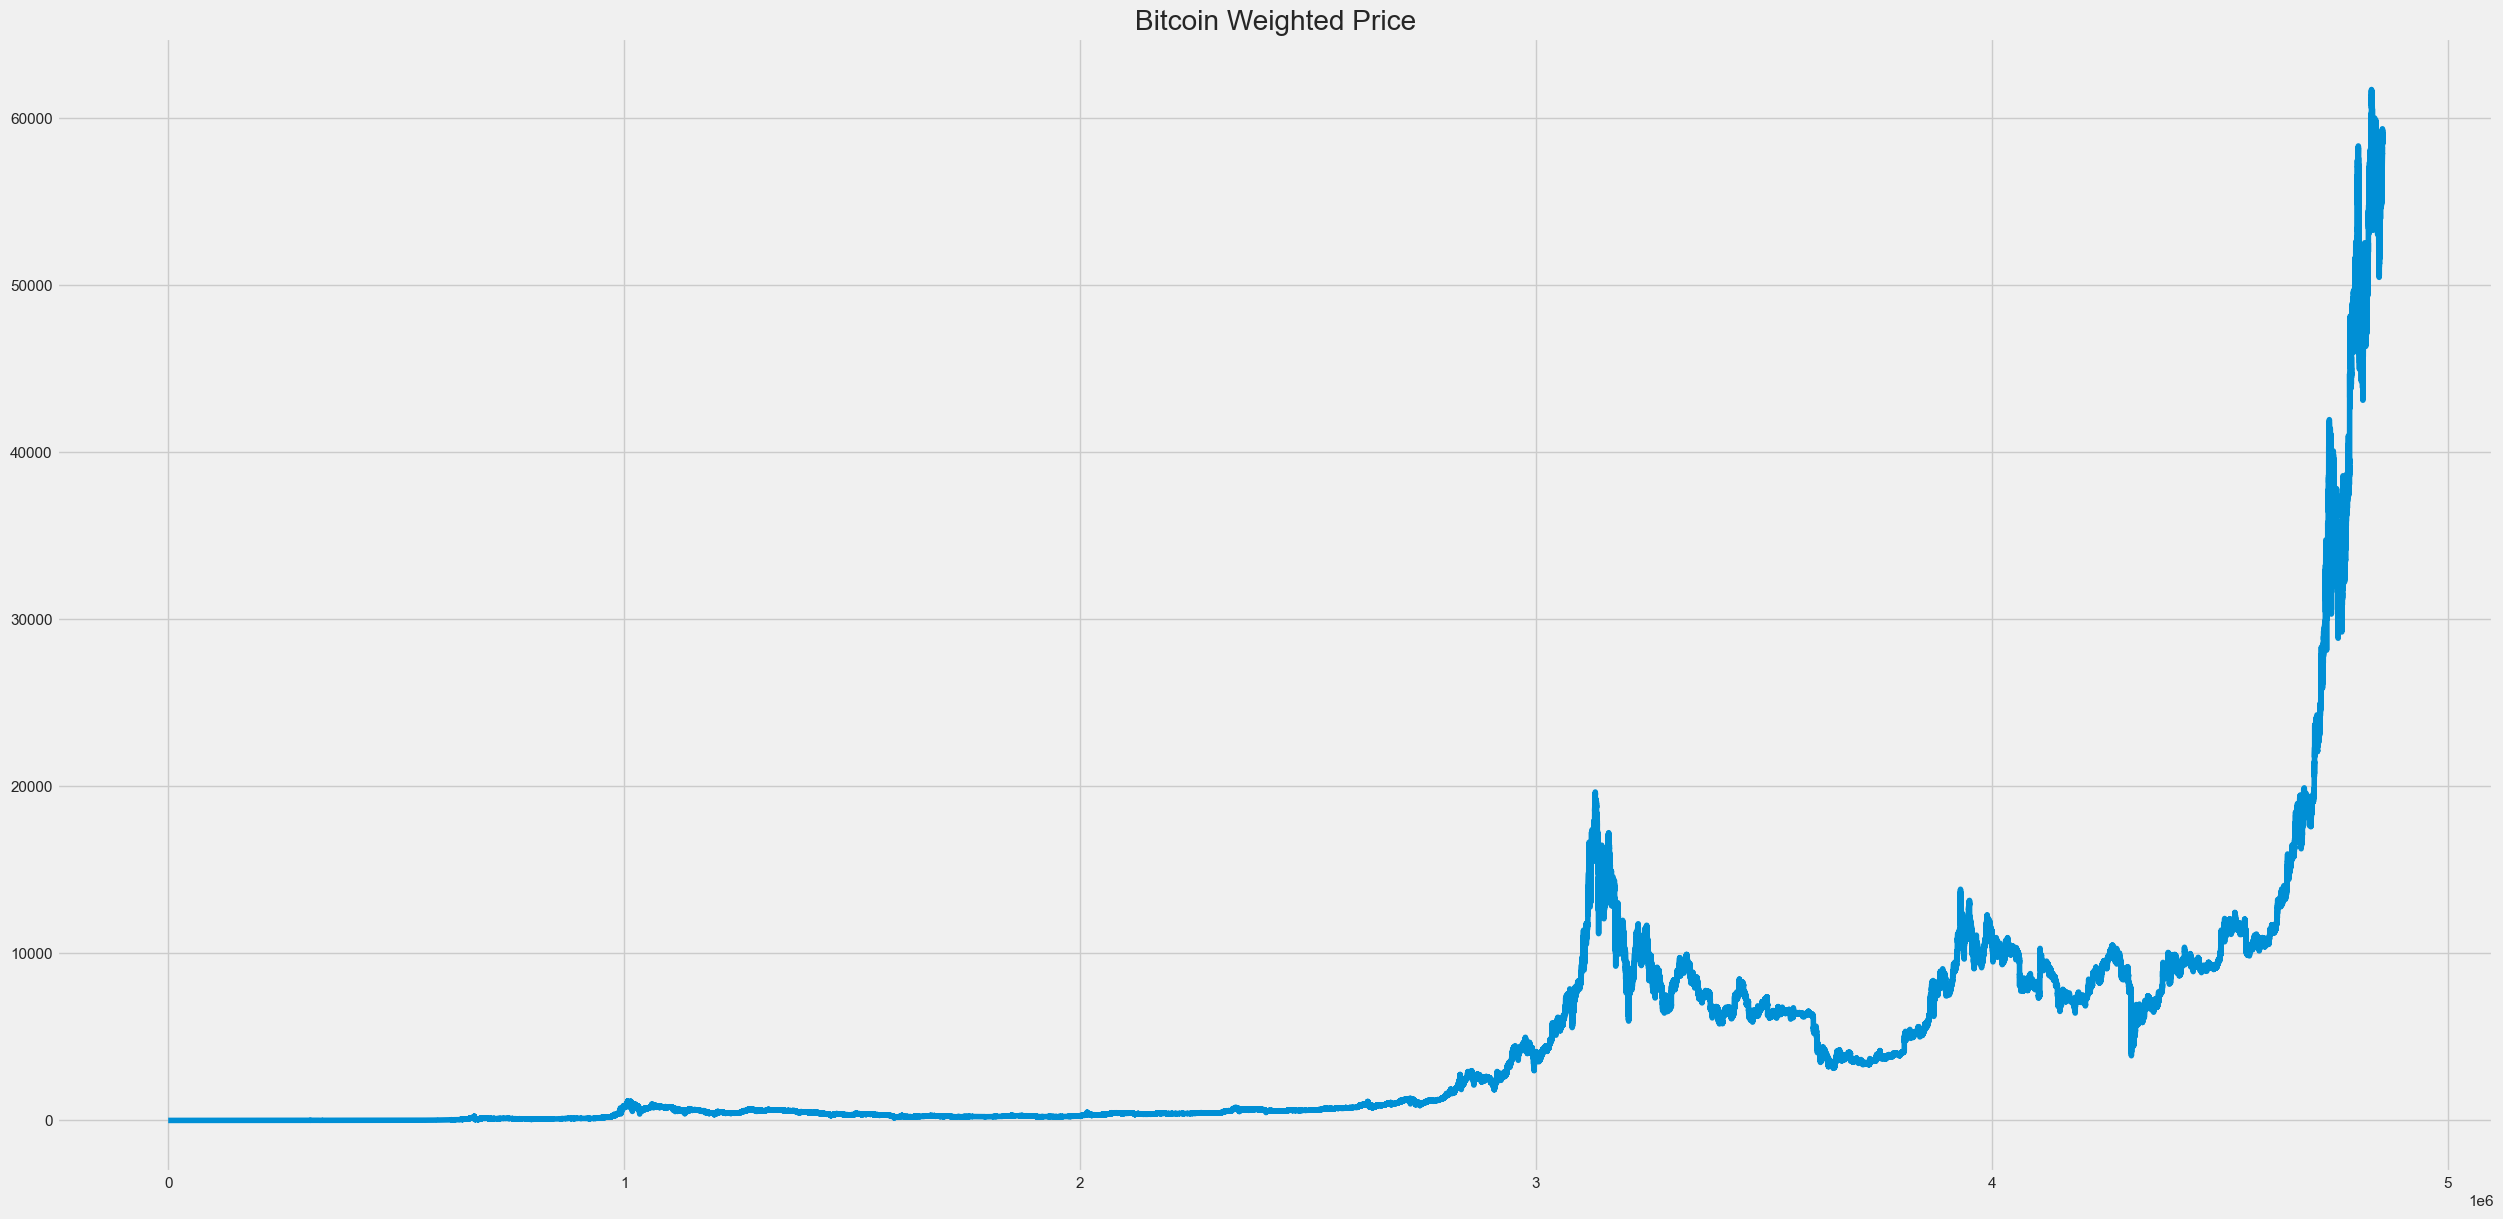

In [32]:
BTC_DF = fill_missing(BTC_DF)
BTC_DF.Weighted_Price.plot(figsize=(28,14), title="Bitcoin Weighted Price")

SETTING TIMESTAMP AS INDEX

In [33]:
BTC_DF = BTC_DF.set_index('Timestamp')
BTC_DF.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 13:22:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.39
2011-12-31 13:23:00,4.39,4.39,4.39,4.39,0.555046,2.436653,4.39
2011-12-31 13:24:00,4.39,4.39,4.39,4.39,0.654511,2.873305,4.39
2011-12-31 13:25:00,4.39,4.39,4.39,4.39,0.753977,3.309958,4.39
2011-12-31 13:26:00,4.39,4.39,4.39,4.39,0.853442,3.746611,4.39


# PLOTS

PLOT 1

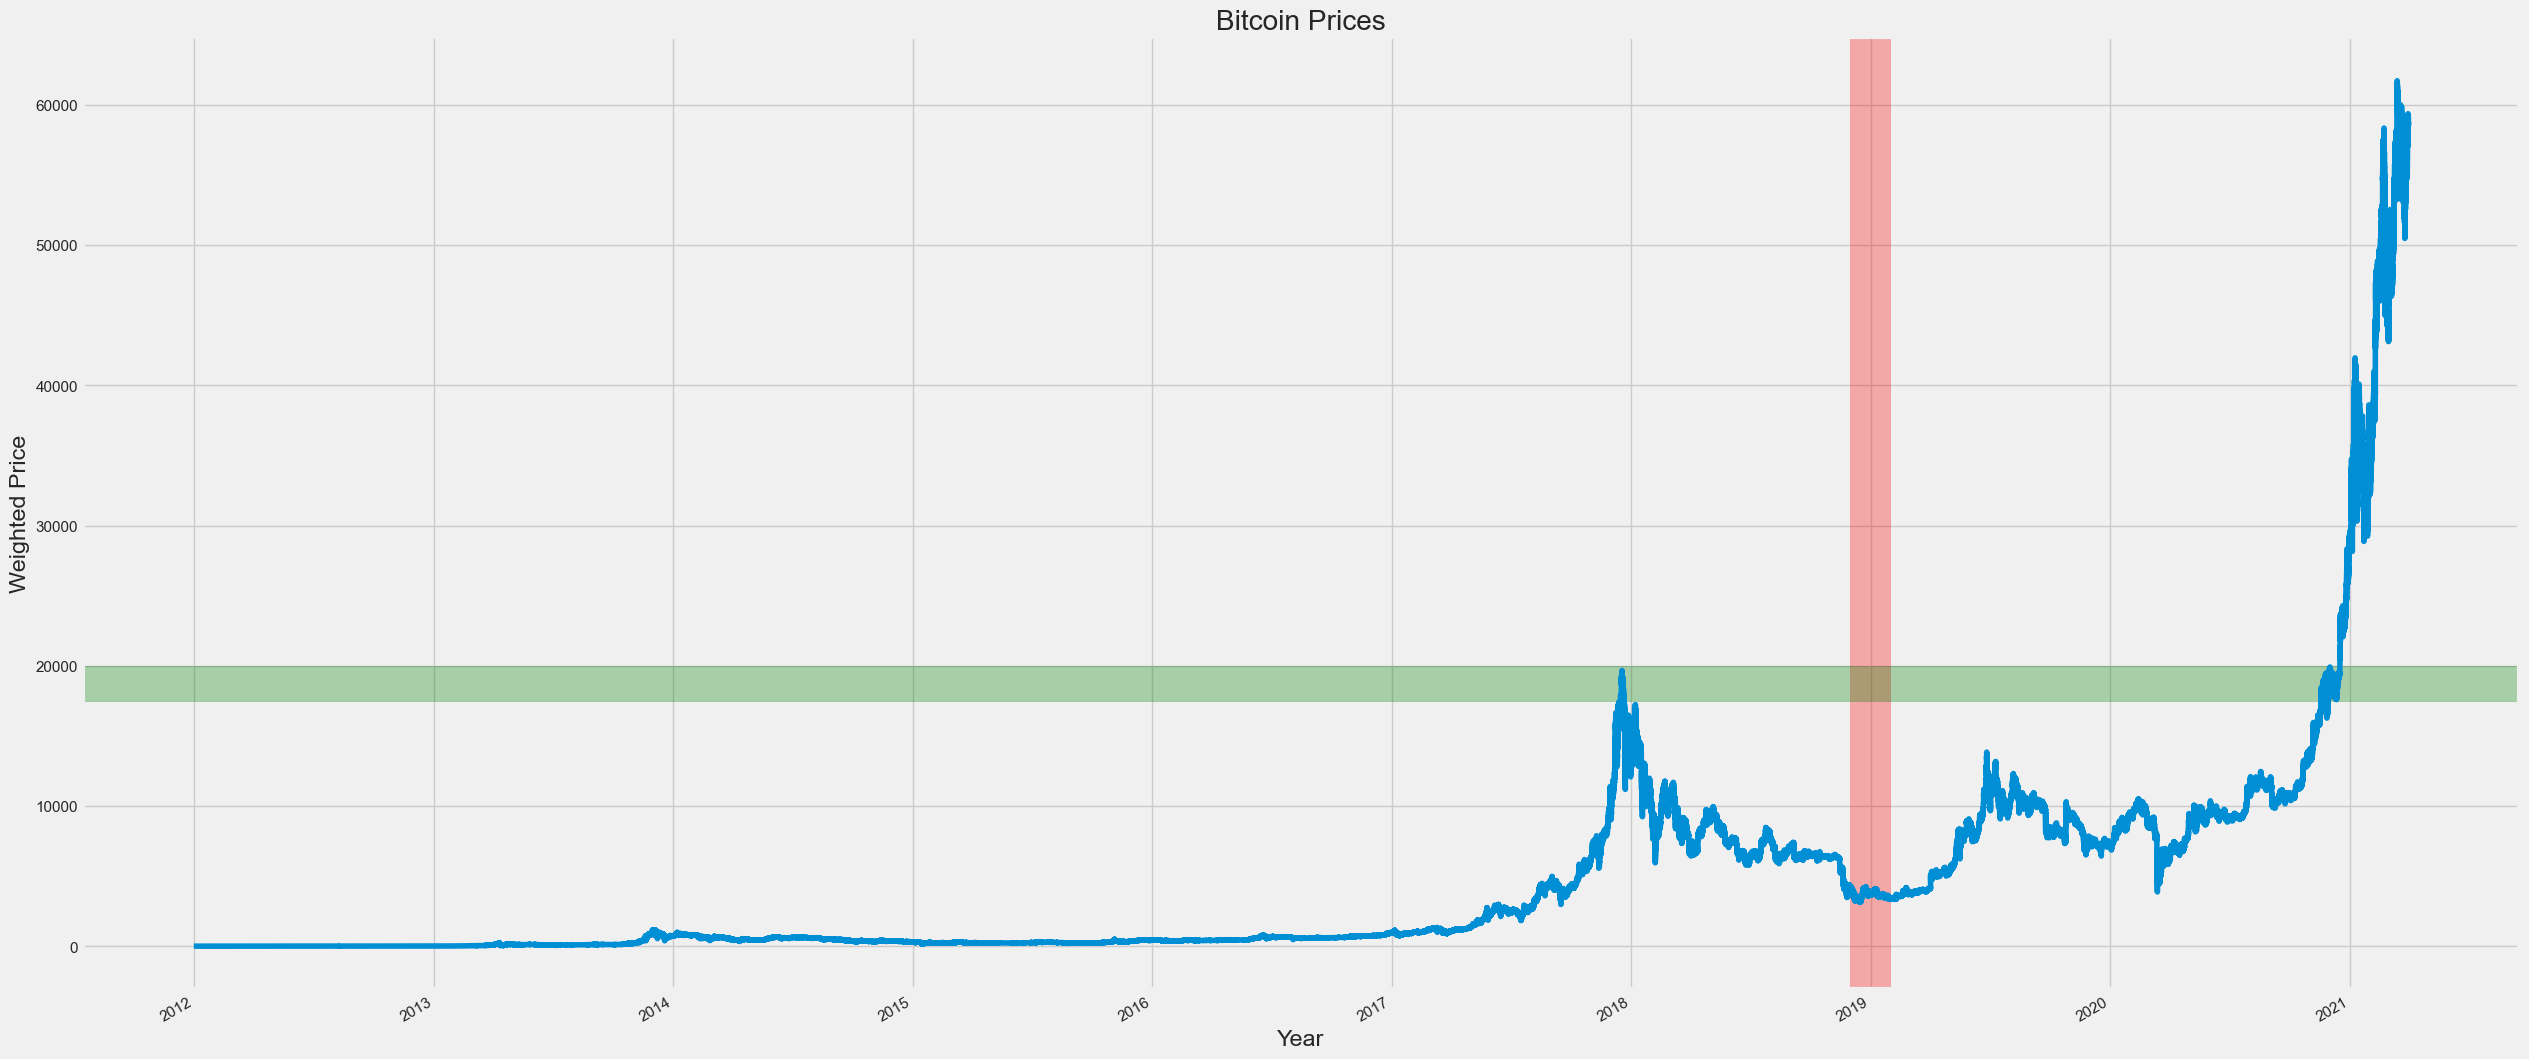

In [34]:
ax = BTC_DF['Weighted_Price'].plot(title='Bitcoin Prices', grid=True, figsize=(28,14))
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Price')

ax.axvspan('2018-12-01','2019-01-31',color='red', alpha=0.3)
ax.axhspan(17500,20000, color='green',alpha=0.3)

PLOT 2

Text(0, 0.5, 'Weighted_Price')

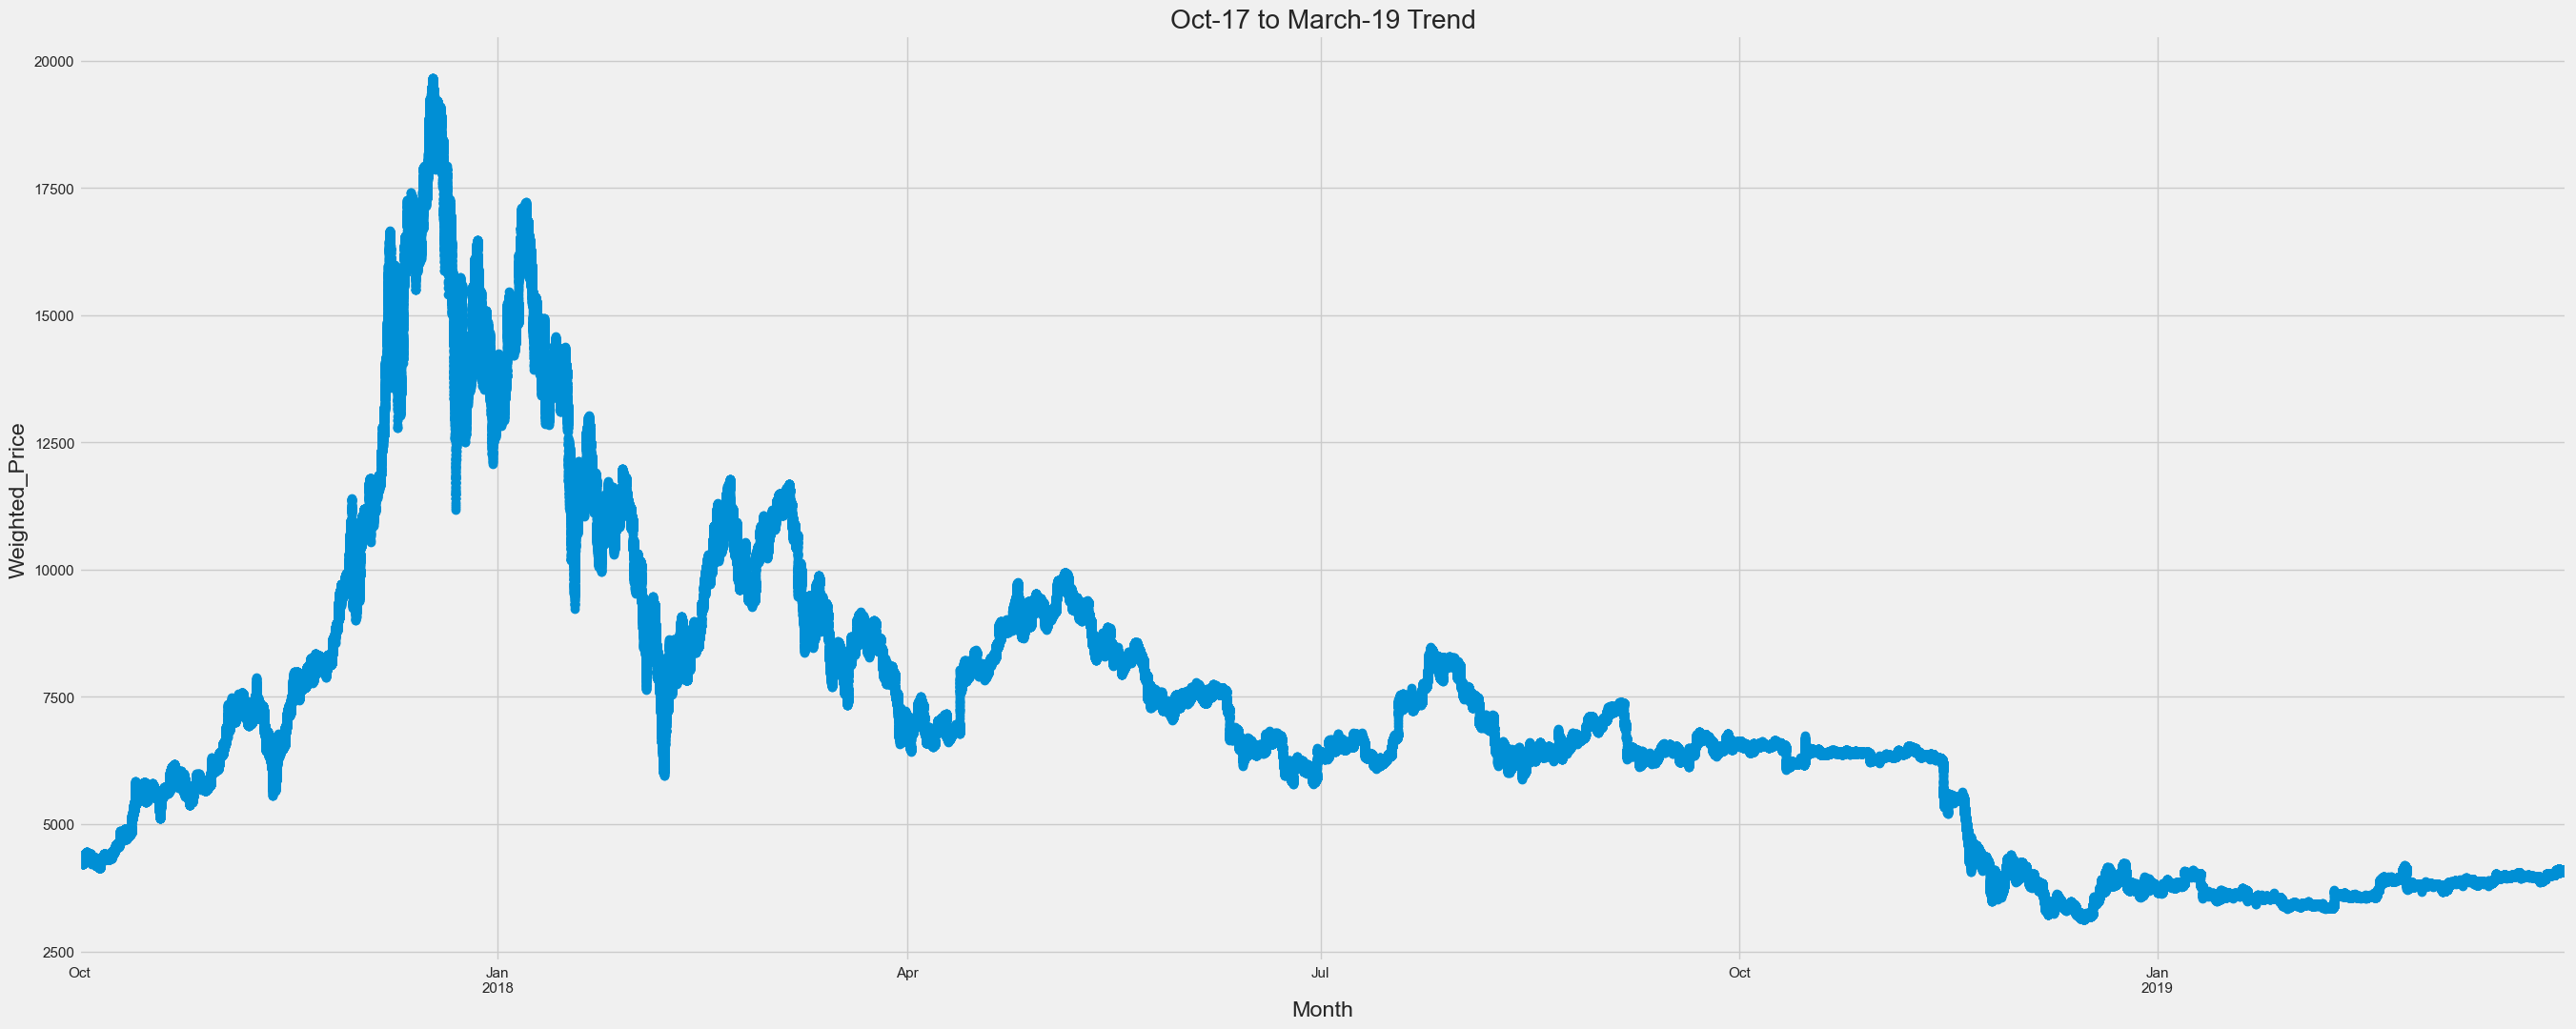

In [35]:
#Zooming in
ax = BTC_DF.loc['2017-10':'2019-03','Weighted_Price'].plot(marker='o', linestyle='-',figsize=(30,12), title="Oct-17 to March-19 Trend", grid=True)
ax.set_xlabel('Month')
ax.set_ylabel('Weighted_Price')

PLOT 3

<Axes: xlabel='Weighted_Price', ylabel='Density'>

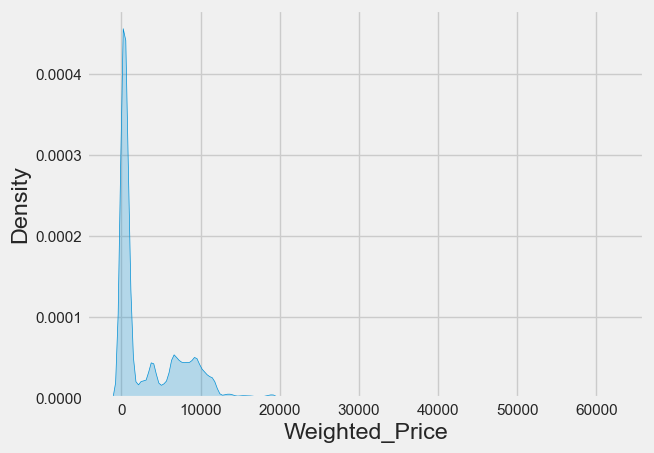

In [36]:
sns.kdeplot(BTC_DF['Weighted_Price'], fill=True)

PLOT 4

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


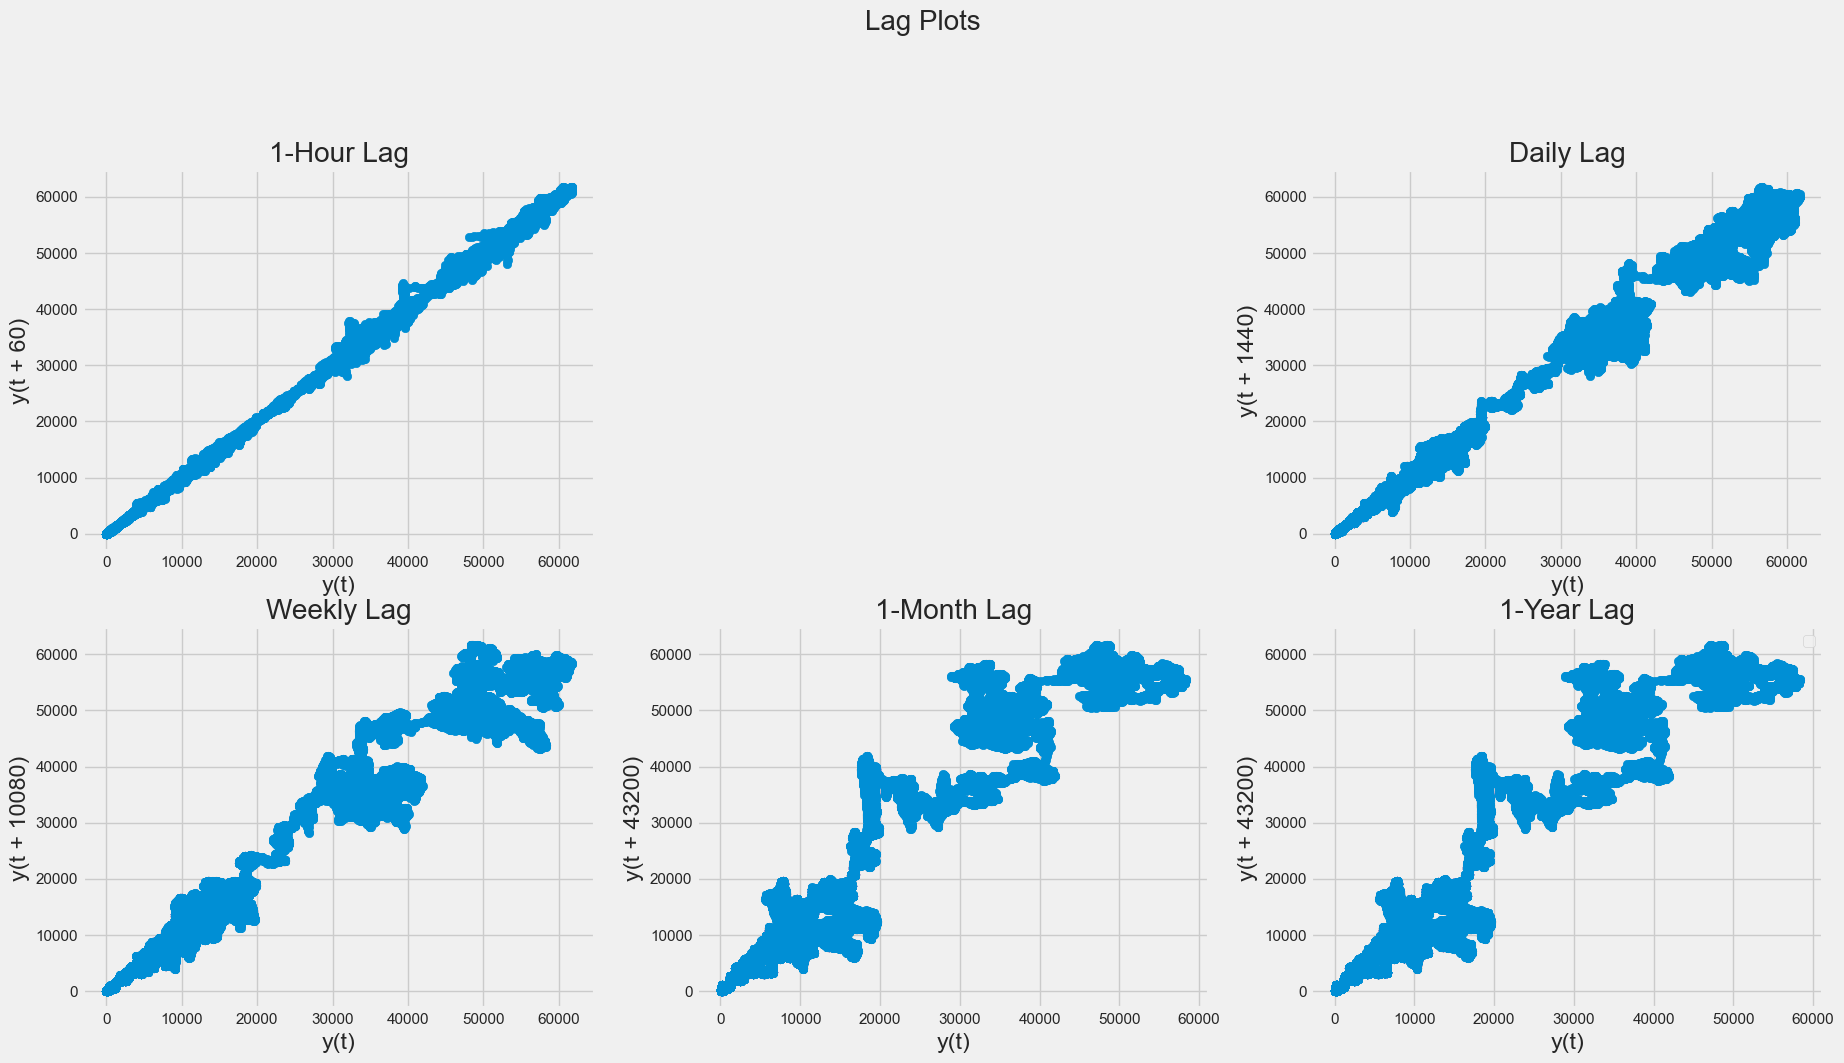

In [37]:
plt.figure(figsize=(20,16))
plt.suptitle('Lag Plots', fontsize=20)

plt.subplot(3,3,1)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,1)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=60) #hourley lag
plt.title('1-Hour Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=1440) #Daily lag
plt.title('Daily Lag')

plt.subplot(3,3,4)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=10080) #weekly lag
plt.title('Weekly Lag')

plt.subplot(3,3,5)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=43200) #month lag
plt.title('1-Month Lag')

plt.subplot(3,3,6)
pd.plotting.lag_plot(BTC_DF['Weighted_Price'], lag=43200) #Year lag
plt.title('1-Year Lag')

plt.legend()
plt.show()

PLOT 5

In [38]:
BTC_N = BTC_DF.resample("24H").mean() #daily resampling
BTC_N = fill_missing(BTC_N)
BTC_N.reset_index(inplace=True)
fig = px.line(BTC_N, x='Timestamp', y='Weighted_Price', title='Weighted Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=2, label="2y", step="year", stepmode="backward"),
            dict(step="all")
            
        ])
    )
)
fig.show()

                Open      High       Low     Close  Volume_(BTC)  \
Timestamp                                                          
2011-12-31  4.422837  4.426677  4.422837  4.426677     24.024874   
2012-01-01  4.677625  4.677625  4.677625  4.677625      5.883361   
2012-01-02  4.991701  4.991701  4.991701  4.991701     13.503075   
2012-01-03  5.175495  5.175495  5.175495  5.175495     11.136690   
2012-01-04  5.120500  5.133742  5.120500  5.133742      8.327158   

            Volume_(Currency)  Weighted_Price  
Timestamp                                      
2011-12-31         105.980529        4.424286  
2012-01-01          27.923145        4.677625  
2012-01-02          67.432386        4.991701  
2012-01-03          56.749845        5.175495  
2012-01-04          43.510443        5.125202  
Open                 0
High                 0
Low                  0
Close                0
Volume_(BTC)         0
Volume_(Currency)    0
Weighted_Price       0
dtype: int64


PLOT 6

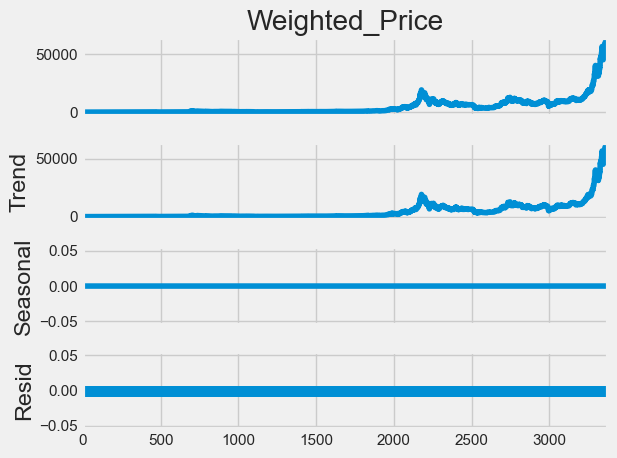

<Figure size 3000x2400 with 0 Axes>

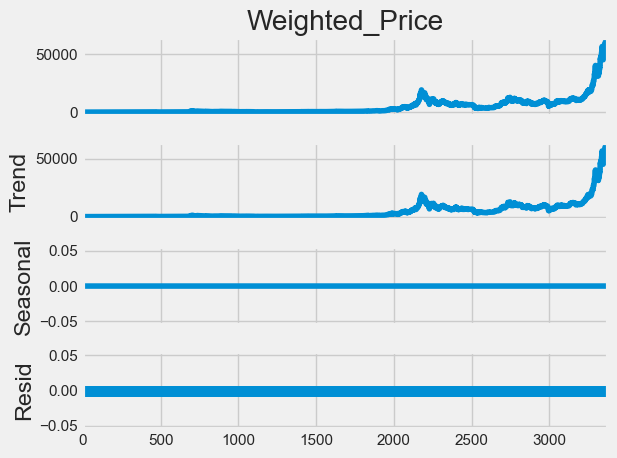

In [39]:
plt.figure(figsize=(30,24))
series = BTC_N.Weighted_Price
result = seasonal_decompose(series, model='additive',period=1)
trend = result.trend
seasonal = result.seasonal
result.plot()

PLOT 7

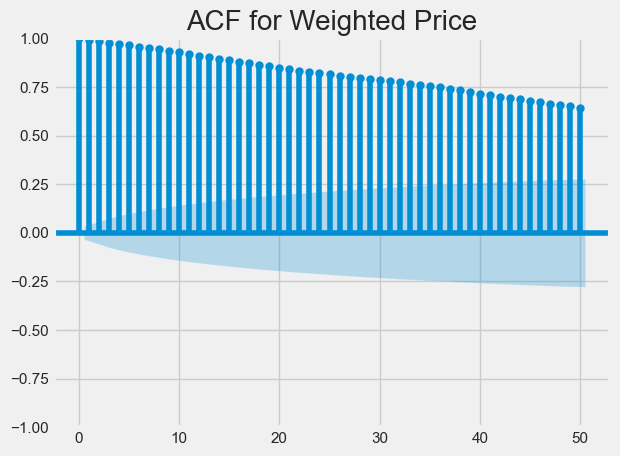

In [40]:
acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Weighted Price", size=20)
plt.show()

PLOT 8

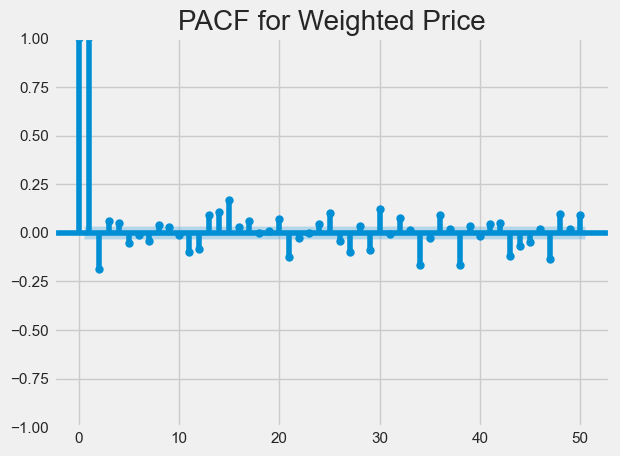

In [41]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Weighted Price", size=20)
plt.show()

CHECKING WHETHER DATA IS STATIONARY OR NOT USING DICKEY-FULLER TEST

In [42]:
adf_test(BTC_N)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\3378030947.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Results of Dickey-Fuller Test:
dftest:  (6.302120534312766, 1.0, 29, 3349, {'1%': -3.432304111473485, '5%': -2.862403412310526, '10%': -2.56722961145352}, 48472.31981125205)
Test Statistic                    6.302121
p-value                           1.000000
#Lags Used                       29.000000
Number of Observations Used    3349.000000
Critical Value (1%)              -3.432304
Critical Value (5%)              -2.862403
Critical Value (10%)             -2.567230
dtype: float64
Series is Stationary




MAKING A COPY OF THE DATAFRAME

In [43]:
BTC_N.head()
df = BTC_N.set_index("Timestamp")

DATA ENCRYPTION

In [44]:
path = r'bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
with open(path, 'rb') as opened_file:
  content=opened_file.read()
  sha256 = hashlib.sha256()
  sha256.update(content)
  print('{}: {}'.format('Cipher Text', sha256.hexdigest()))

Cipher Text: f1f7ac05bae91911673dff036fcb596a1f27ff4659d54a9538153d5c71331654


# PREPARING DATA FOR MODEL BUILDING

FEATURE EXTRACTION

In [45]:
df.reset_index(drop=False, inplace=True)

rolling_features = ["Open", "High", "Low", "Close","Volume_(BTC)"]
window1 = 3
window2 = 7
window3 = 30
window4 = 365

df_rolled_3d = df[rolling_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[rolling_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[rolling_features].rolling(window=window3, min_periods=0)
df_rolled_365d = df[rolling_features].rolling(window=window4, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index()
df_mean_365d = df_rolled_365d.mean().shift(1).reset_index()

df_std_3d = df_rolled_3d.std().shift(1).reset_index()
df_std_7d = df_rolled_7d.std().shift(1).reset_index()
df_std_30d = df_rolled_30d.std().shift(1).reset_index()
df_std_365d = df_rolled_365d.std().shift(1).reset_index()

In [46]:
for feature in rolling_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]
    df[f"{feature}_mean_lag{window4}"] = df_mean_365d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]
    df[f"{feature}_std_lag{window4}"] = df_std_365d[feature]

df.fillna(df.mean(), inplace=True)

df.set_index("Timestamp", drop=False, inplace=True)

In [47]:
df["year"] = df.Timestamp.dt.year
df["month"] = df.Timestamp.dt.month
df["day"] = df.Timestamp.dt.day
df["day_of_week"] = df.Timestamp.dt.dayofweek
df["day_of_year"] = df.Timestamp.dt.dayofyear

df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_mean_lag3,Open_mean_lag7,...,Volume_(BTC)_mean_lag365,Volume_(BTC)_std_lag3,Volume_(BTC)_std_lag7,Volume_(BTC)_std_lag30,Volume_(BTC)_std_lag365,year,month,day,day_of_week,day_of_year
Timestamp,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2011-12-31,4.422837,4.426677,4.422837,4.426677,24.024874,105.980529,4.424286,4564.752758,4532.014863,...,9.833039,3.369452,4.136303,5.128796,6.974458,2011,12,31,5,365
2012-01-01,2012-01-01,4.677625,4.677625,4.677625,4.677625,5.883361,27.923145,4.677625,4.422837,4.422837,...,24.024874,3.369452,4.136303,5.128796,6.974458,2012,1,1,6,1
2012-01-02,2012-01-02,4.991701,4.991701,4.991701,4.991701,13.503075,67.432386,4.991701,4.550231,4.550231,...,14.954117,12.827987,12.827987,12.827987,12.827987,2012,1,2,0,2
2012-01-03,2012-01-03,5.175495,5.175495,5.175495,5.175495,11.136690,56.749845,5.175495,4.697388,4.697388,...,14.470437,9.109362,9.109362,9.109362,9.109362,2012,1,3,1,3
2012-01-04,2012-01-04,5.120500,5.133742,5.120500,5.133742,8.327158,43.510443,5.125202,4.948274,4.816915,...,13.637000,3.899942,7.622256,7.622256,7.622256,2012,1,4,2,4


In [48]:
df_day = df.resample('D').mean()  # Daily resampling
missing_replacement = df['2015-01-05': '2015-01-09'].mean(numeric_only=True)
df_day.loc['2015-01-06'] = missing_replacement
df_day.loc['2015-01-07'] = missing_replacement
df_day.loc['2015-01-08'] = missing_replacement

# Showing missing values
df_day.isnull().sum()

Timestamp                   3
Open                        0
High                        0
Low                         0
Close                       0
Volume_(BTC)                0
Volume_(Currency)           0
Weighted_Price              0
Open_mean_lag3              0
Open_mean_lag7              0
Open_mean_lag30             0
Open_mean_lag365            0
Open_std_lag3               0
Open_std_lag7               0
Open_std_lag30              0
Open_std_lag365             0
High_mean_lag3              0
High_mean_lag7              0
High_mean_lag30             0
High_mean_lag365            0
High_std_lag3               0
High_std_lag7               0
High_std_lag30              0
High_std_lag365             0
Low_mean_lag3               0
Low_mean_lag7               0
Low_mean_lag30              0
Low_mean_lag365             0
Low_std_lag3                0
Low_std_lag7                0
Low_std_lag30               0
Low_std_lag365              0
Close_mean_lag3             0
Close_mean

In [49]:
exogenous_features = ['Open_mean_lag3',
       'Open_mean_lag7', 'Open_mean_lag30', 'Open_std_lag3', 'Open_std_lag7',
       'Open_std_lag30', 'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30',
       'High_std_lag3', 'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3',
       'Low_mean_lag7', 'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7',
       'Low_std_lag30', 'Close_mean_lag3', 'Close_mean_lag7',
       'Close_mean_lag30', 'Close_std_lag3', 'Close_std_lag7',
       'Close_std_lag30', 'Volume_(BTC)_mean_lag3', 'Volume_(BTC)_mean_lag7',
       'Volume_(BTC)_mean_lag30', 'Volume_(BTC)_std_lag3',
       'Volume_(BTC)_std_lag7', 'Volume_(BTC)_std_lag30', 'month', #'week',
       'day', 'day_of_week', 'year','day_of_year']

SPLITTING DATA INTO TRAING AND TEST SET FOR MODEL BUILDING AND PREDICTION

In [50]:
df_train = df_day.loc['2011-12-31':'2020-05-10']
df_test = df_day.loc['2020-05-11':]

X_train, y_train = df_train[exogenous_features], df_train.Weighted_Price
X_test, y_test = df_test[exogenous_features], df_test.Weighted_Price

# MODEL BUILD

XGBOOST

In [51]:
reg = xgb.XGBRegressor()

In [52]:
## Hyper Parameter Optimization Grid

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1], 
}

In [53]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=10,
                n_jobs=-1,
                cv=5,
                verbose=3,
)

In [54]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                              0.8, 0.9, 1],
                                        'colsample_bytree': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [1, 3, 4, 5, 6, 7],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   verbose=3)

In [55]:
model.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=None, colsample_bytree=0.9,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.25, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=7, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1577,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

DATA & PLOT (XGBOOST TRAINING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\4020796350.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

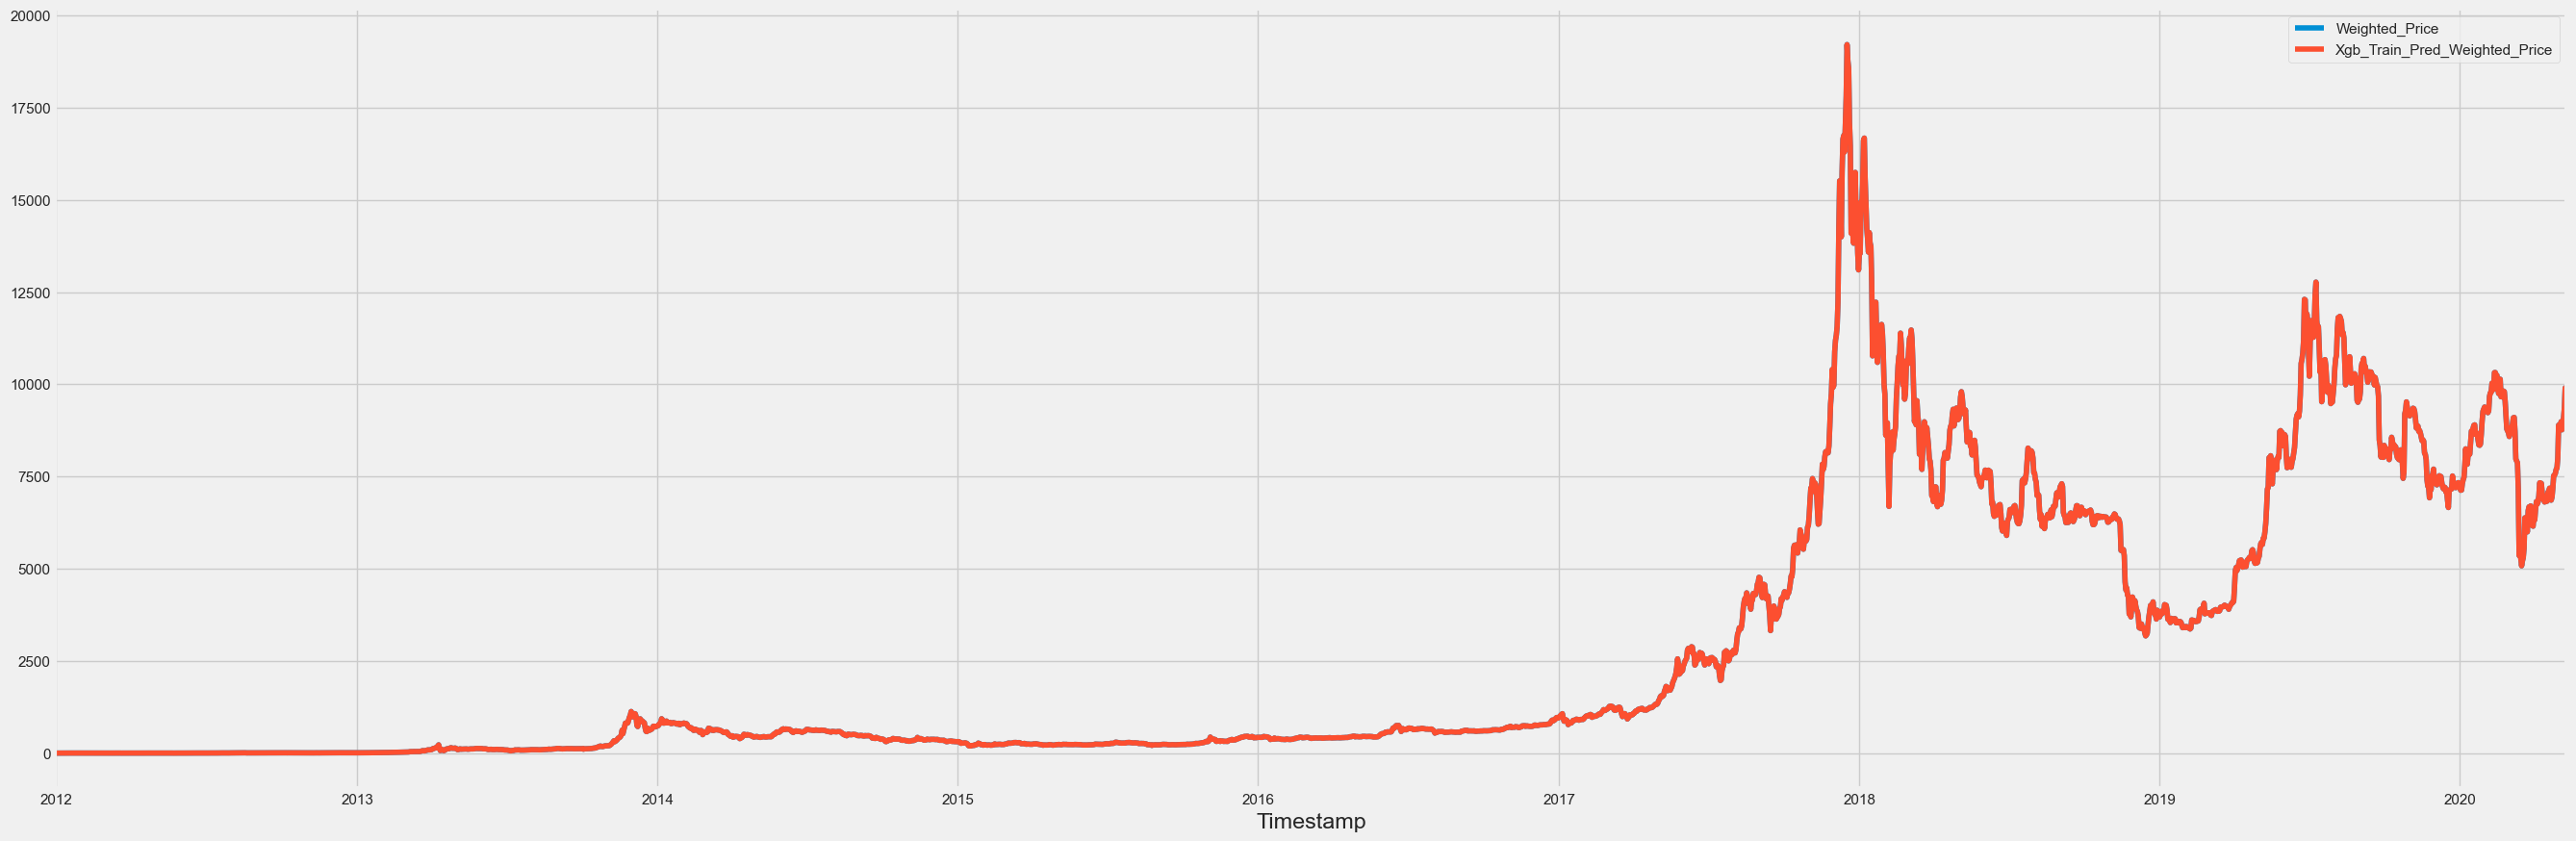

In [56]:
df_train['Xgb_Train_Pred_Weighted_Price'] = model.predict(X_train)

df_train[['Weighted_Price','Xgb_Train_Pred_Weighted_Price']].plot(figsize=(30, 10))

DATA & PLOT (XGBOOST TESTING SET)

In [57]:
df_test['Xgb_Test_Pred_Weighted_Price'] = model.predict(X_test)

compare_df = pd.concat([df_train, df_test], sort=False)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\1656217126.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

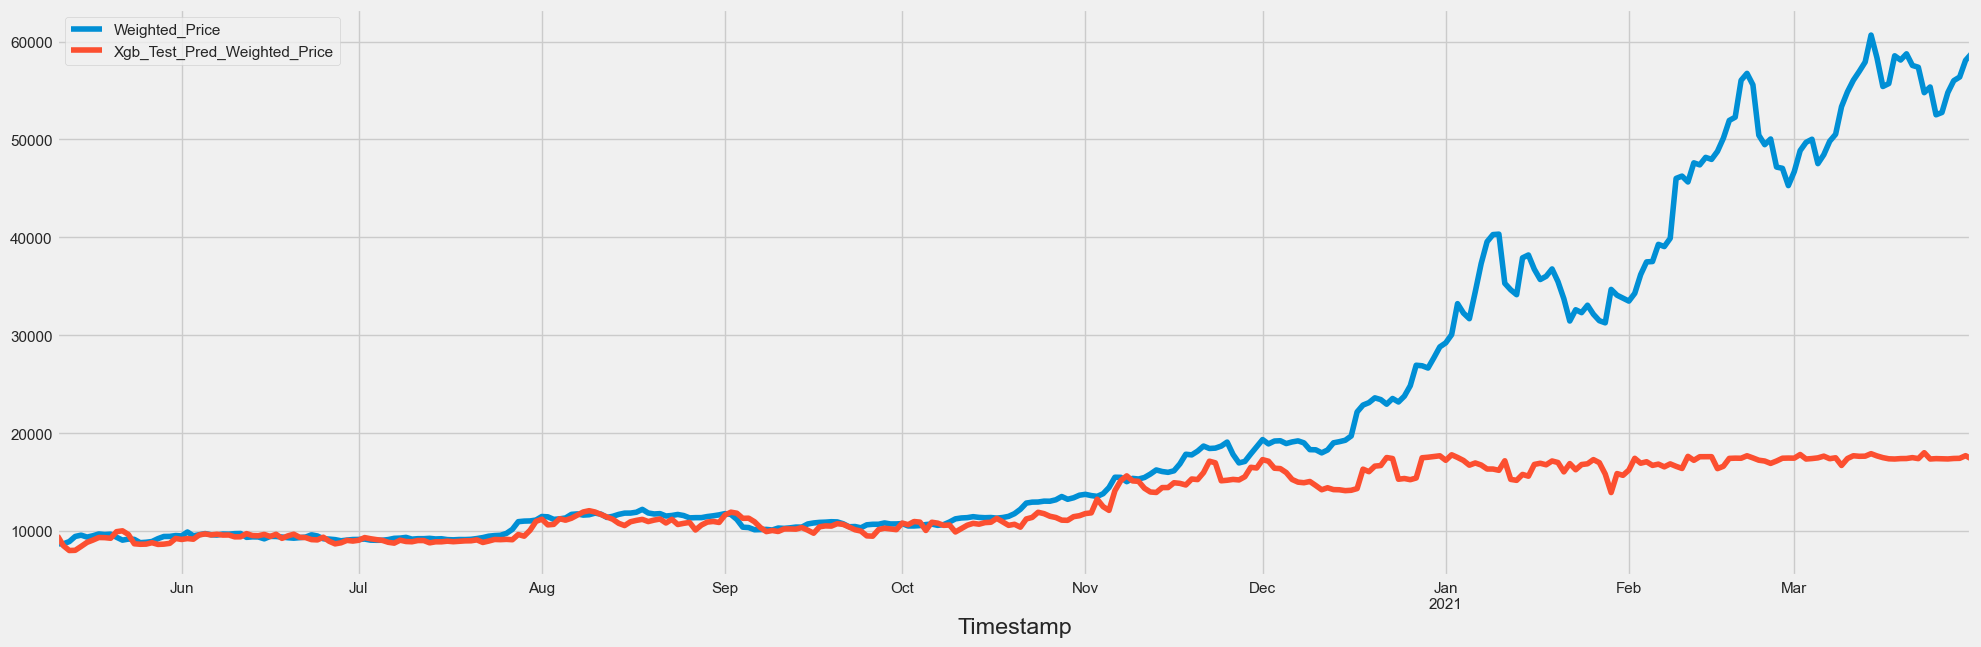

In [58]:
df_test[['Weighted_Price','Xgb_Test_Pred_Weighted_Price']].plot(figsize=(22, 7))

MAE & RMSE CALCULATION FOR TRAINIG & TESTING DATA SET (XGBOOST)

In [59]:
train_mae_xgboost, train_rmse_xgboost = mae_rmse_score(df_train['Weighted_Price'],df_train['Xgb_Train_Pred_Weighted_Price'])
test_mae_xgboost, test_rmse_xgboost = mae_rmse_score(df_test['Weighted_Price'],df_test['Xgb_Test_Pred_Weighted_Price'])

print(f"train MAE XGBOOST : {train_mae_xgboost}")
print(f"train RMSE XGBOOST: {train_rmse_xgboost}")
print()
print(f"test MAE XGBOOST : {test_mae_xgboost}")
print(f"test RMSE XGBOOST : {test_rmse_xgboost}")

train MAE XGBOOST : 0.39
train RMSE XGBOOST: 0.51

test MAE XGBOOST : 8743.39
test RMSE XGBOOST : 15610.55


OVERALL AND EACH DATA MAPE SCORE (XGBOOST)

In [60]:
overall_mape_xgb = mape_score(df_test['Weighted_Price'], df_test['Xgb_Test_Pred_Weighted_Price'])
compare_df['MAPE_XGBoost']=compare_df.apply(lambda x : mape_score(x["Weighted_Price"],x["Xgb_Test_Pred_Weighted_Price"]), axis=1)

print("Overall MAPE score (XGBoost): ",overall_mape_xgb)
print('\n---------------------------------\n')
compare_df['MAPE_XGBoost'].dropna()

Overall MAPE score (XGBoost):  22.78

---------------------------------



Timestamp
2020-05-11     9.29
2020-05-12     2.19
2020-05-13    10.19
2020-05-14    14.94
2020-05-15    11.97
              ...  
2021-03-27    68.27
2021-03-28    68.87
2021-03-29    69.05
2021-03-30    69.49
2021-03-31    70.41
Freq: D, Name: MAPE_XGBoost, Length: 325, dtype: float64

SVR

In [61]:
svr = SVR(kernel='rbf', C=1000)
svr.fit(X_train, y_train)

SVR(C=1000)

DATA & PLOT (SVR TRAINING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\3023756132.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

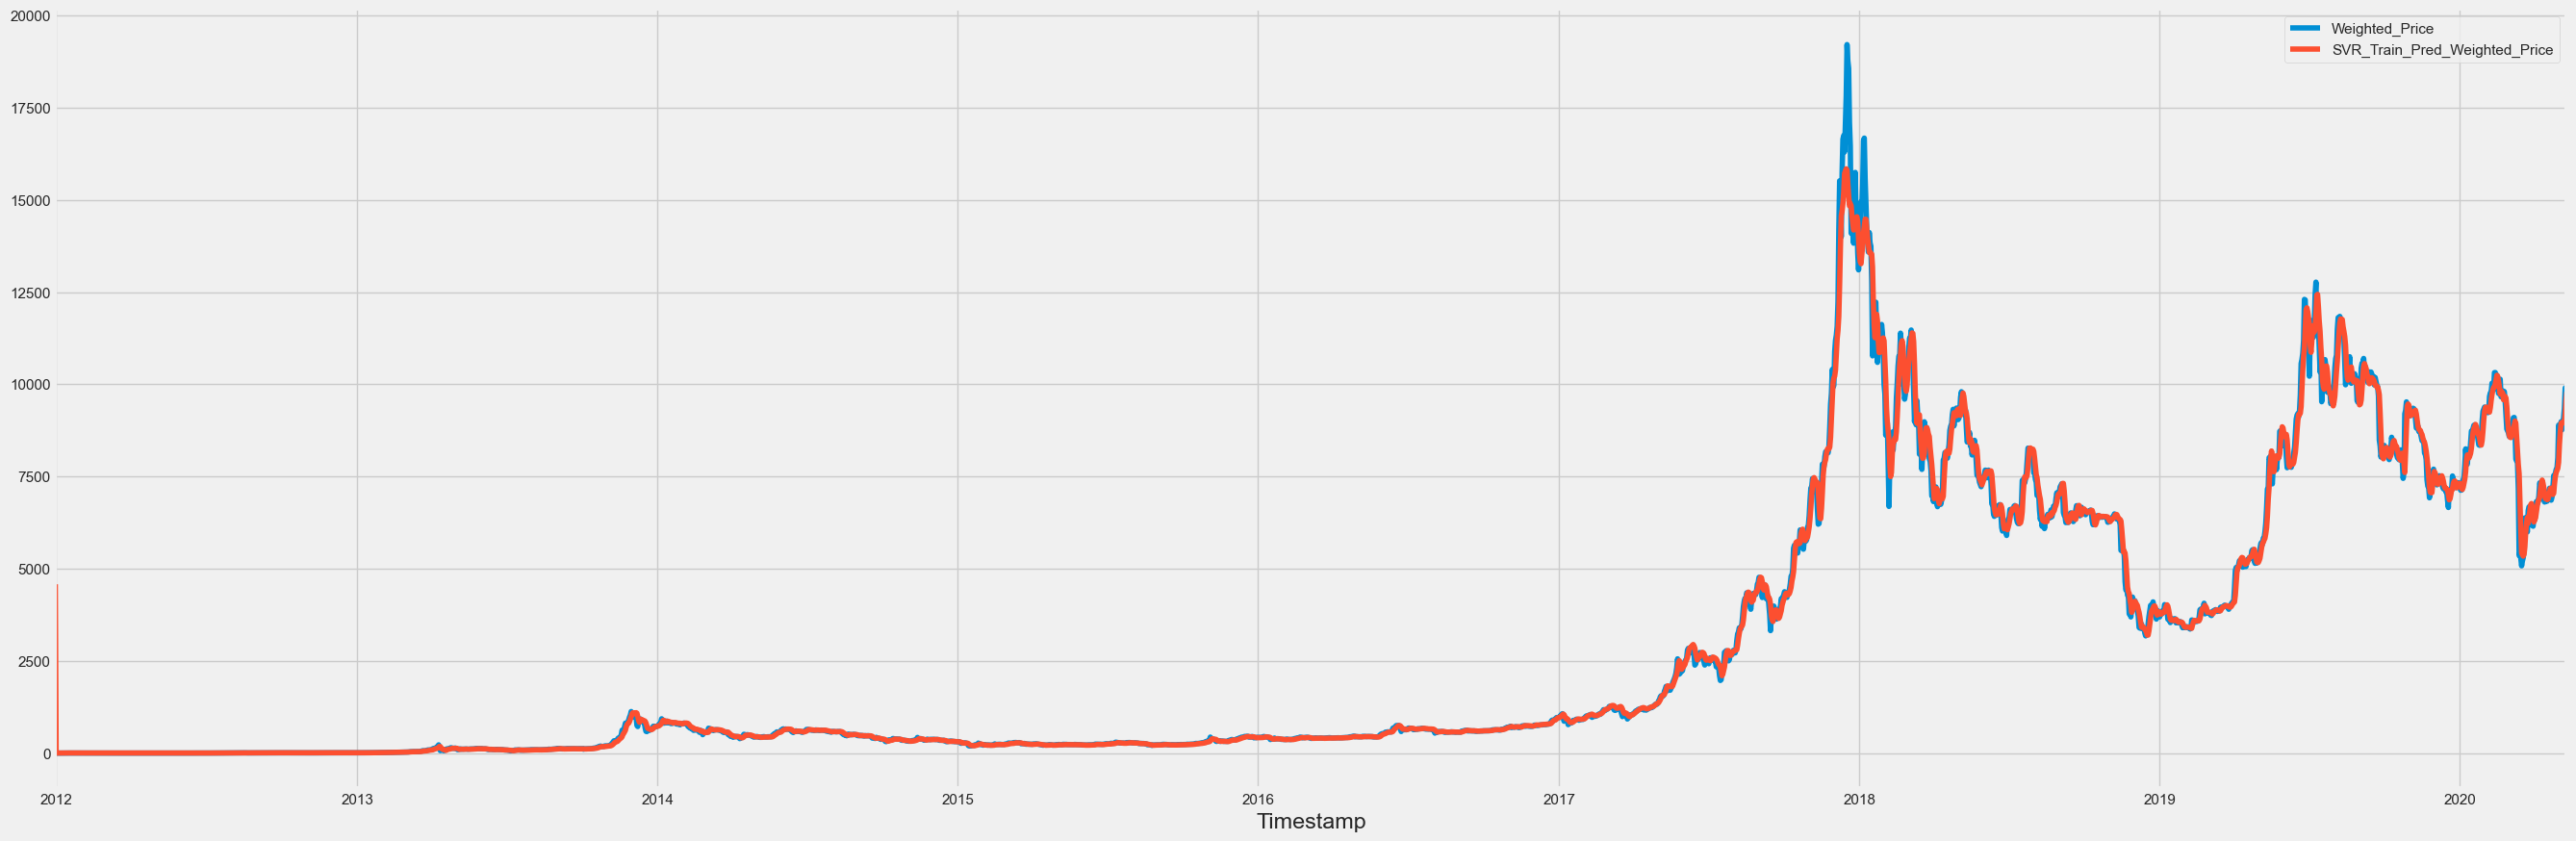

In [62]:
df_train['SVR_Train_Pred_Weighted_Price'] = svr.predict(X_train)

df_train[['Weighted_Price','SVR_Train_Pred_Weighted_Price']].plot(figsize=(30, 10))

DATA & PLOT (SVR TESTING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\3425841686.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

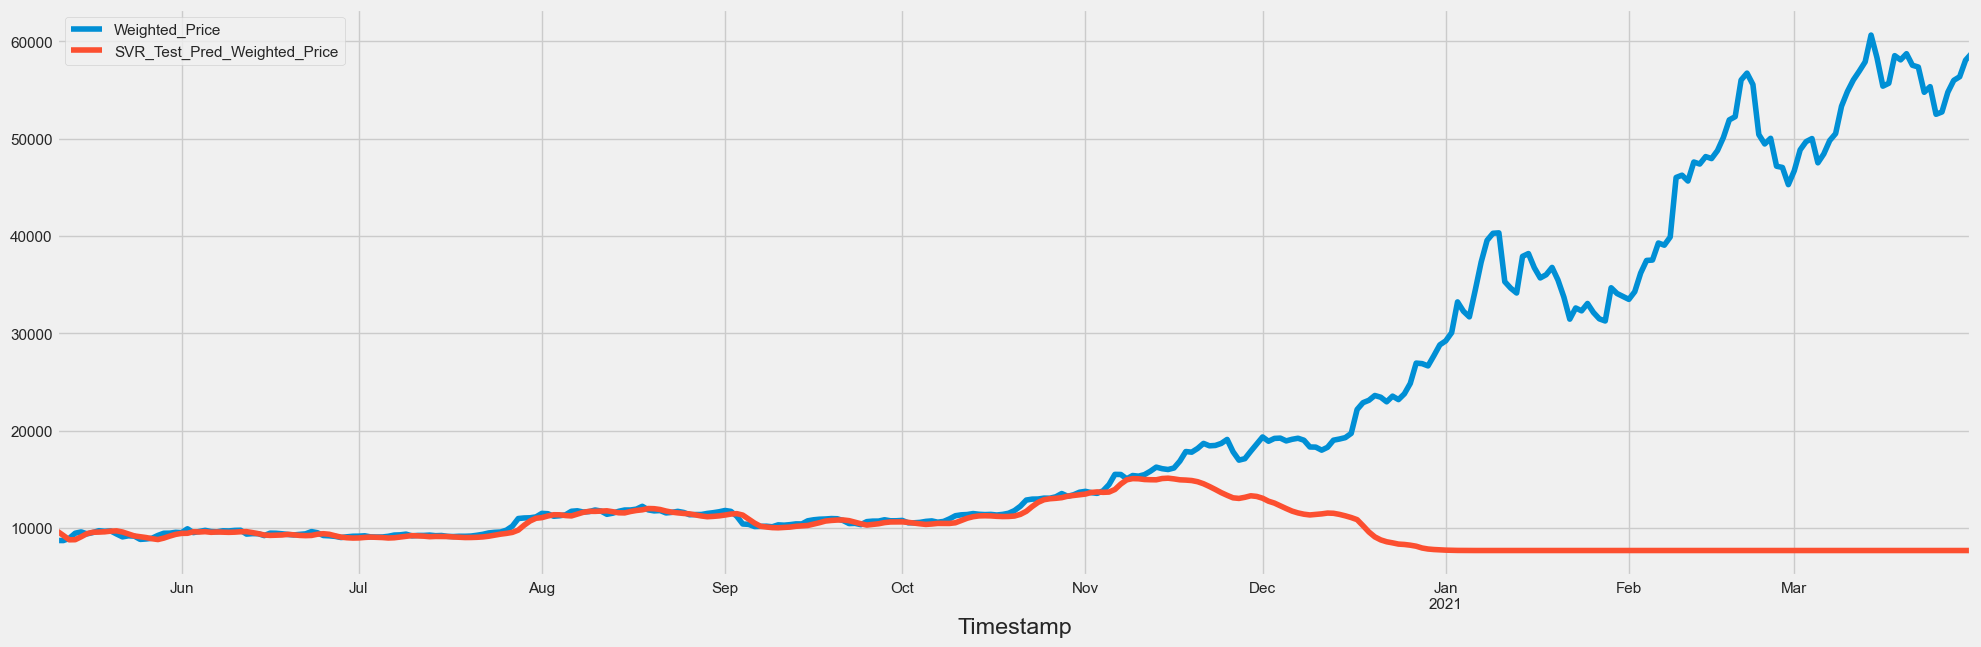

In [63]:
df_test['SVR_Test_Pred_Weighted_Price'] = svr.predict(X_test)

compare_df = pd.concat([df_train, df_test], sort=False)
df_test[['Weighted_Price','SVR_Test_Pred_Weighted_Price']].plot(figsize=(22, 7))

MAE & RMSE CALCULATION FOR TRAINIG & TESTING DATA SET (SVR)

In [64]:
train_mae_svr, train_rmse_svr = mae_rmse_score(df_train['Weighted_Price'],df_train['SVR_Train_Pred_Weighted_Price'])
test_mae_svr, test_rmse_svr = mae_rmse_score(df_test['Weighted_Price'],df_test['SVR_Test_Pred_Weighted_Price'])

print(f"Train MAE SVR : {train_mae_svr}")
print(f"Train RMSE SVR: {train_rmse_svr}")
print()
print(f"Test MAE SVR : {test_mae_svr}")
print(f"Test RMSE SVR: {test_rmse_svr}")

Train MAE SVR : 105.82
Train RMSE SVR: 288.14

Test MAE SVR : 11753.16
Test RMSE SVR: 20626.99


OVERALL AND EACH DATA MAPE SCORE (SVR)

In [65]:
overall_mape_svr = mape_score(df_test['Weighted_Price'], df_test['SVR_Test_Pred_Weighted_Price'])
compare_df['MAPE_SVR']=compare_df.apply(lambda x : mape_score(x["Weighted_Price"],x["SVR_Test_Pred_Weighted_Price"]), axis=1)

print("Overall MAPE score (SVR): ",overall_mape_svr)
print('\n---------------------------------\n')
compare_df['MAPE_SVR'].dropna()

Overall MAPE score (SVR):  29.94

---------------------------------



Timestamp
2020-05-11    10.79
2020-05-12     5.96
2020-05-13     1.71
2020-05-14     7.03
2020-05-15     5.21
              ...  
2021-03-27    85.96
2021-03-28    86.26
2021-03-29    86.35
2021-03-30    86.75
2021-03-31    86.91
Freq: D, Name: MAPE_SVR, Length: 325, dtype: float64

KNN

In [66]:
knn = KNeighborsRegressor(n_neighbors=15)
knn.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=15)

DATA & PLOT (KNN TRAINING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\959044132.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

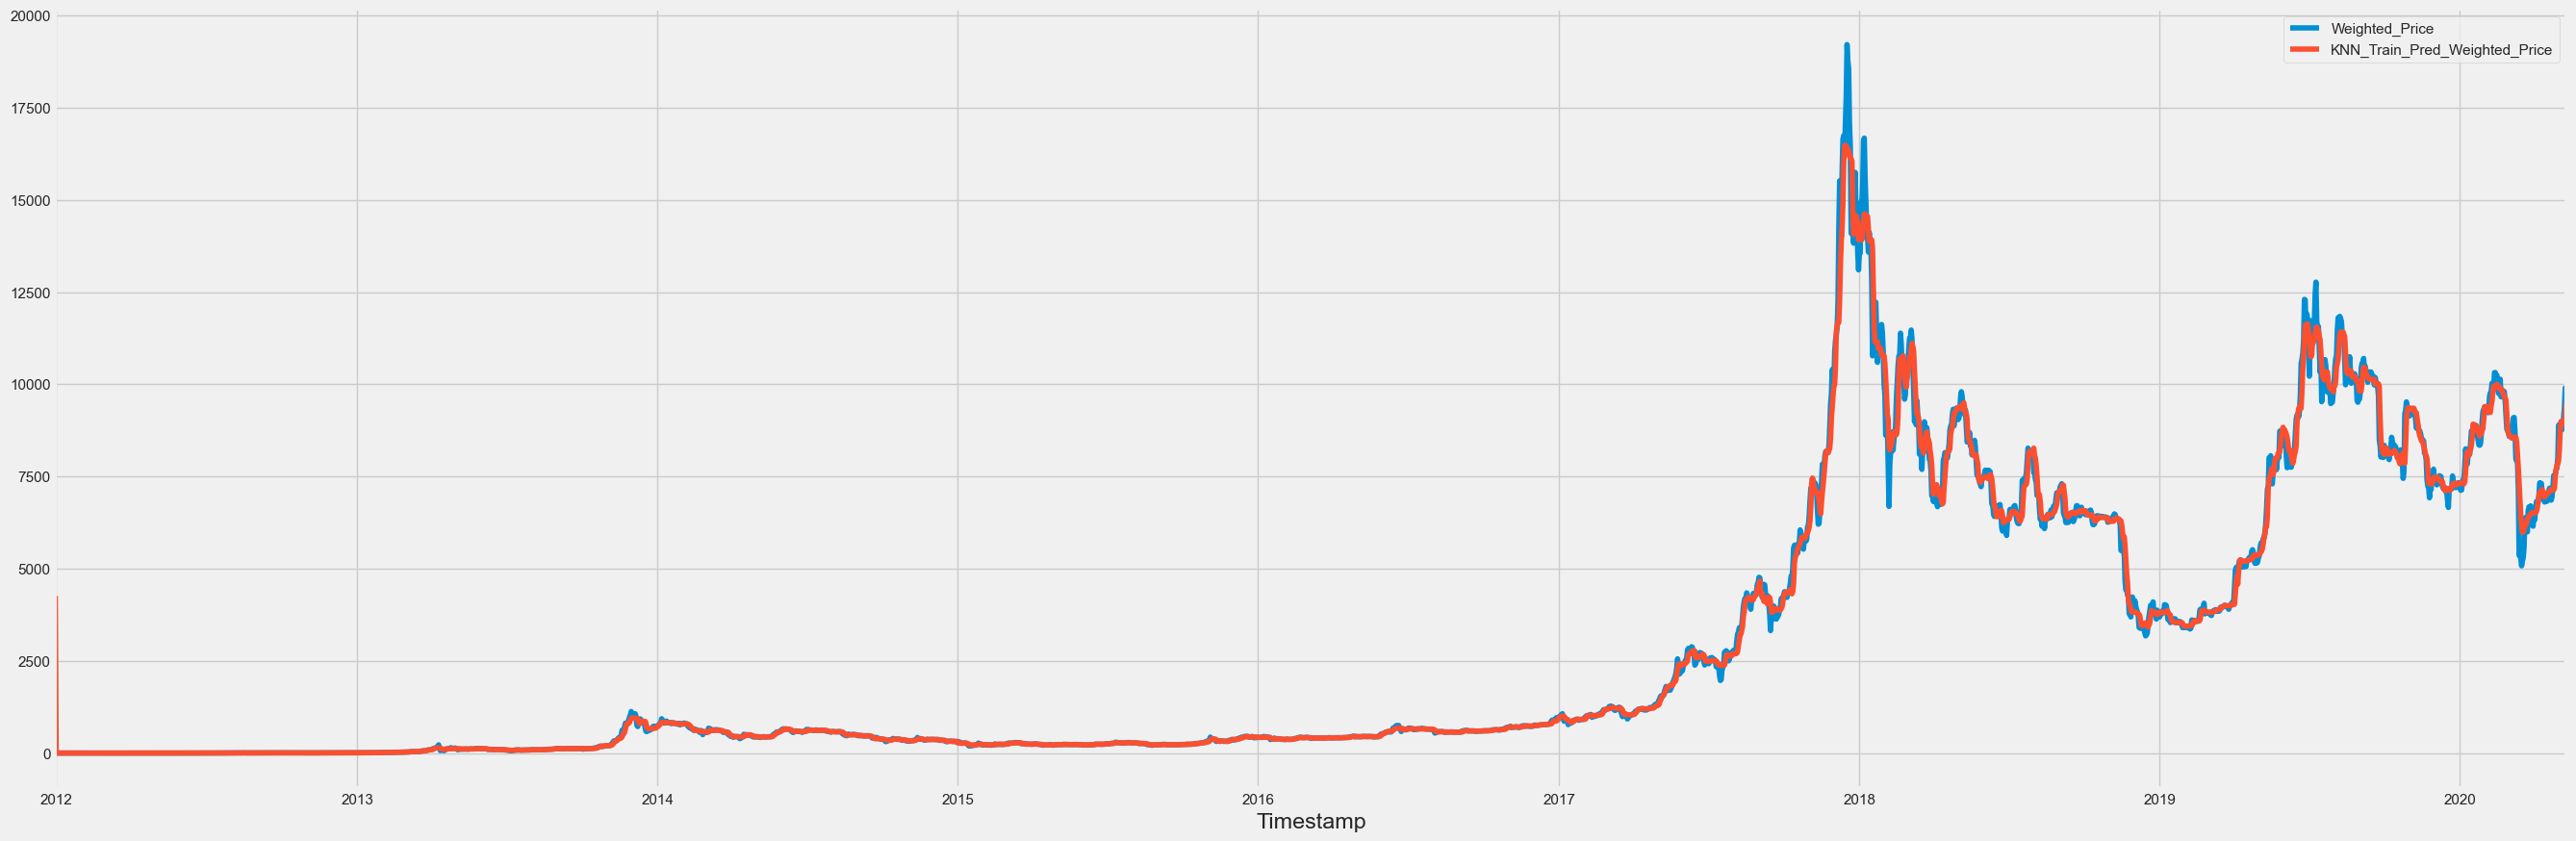

In [67]:
df_train['KNN_Train_Pred_Weighted_Price'] = knn.predict(X_train)

df_train[['Weighted_Price','KNN_Train_Pred_Weighted_Price']].plot(figsize=(30, 10))

DATA & PLOT (KNN TESTING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\2226753190.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

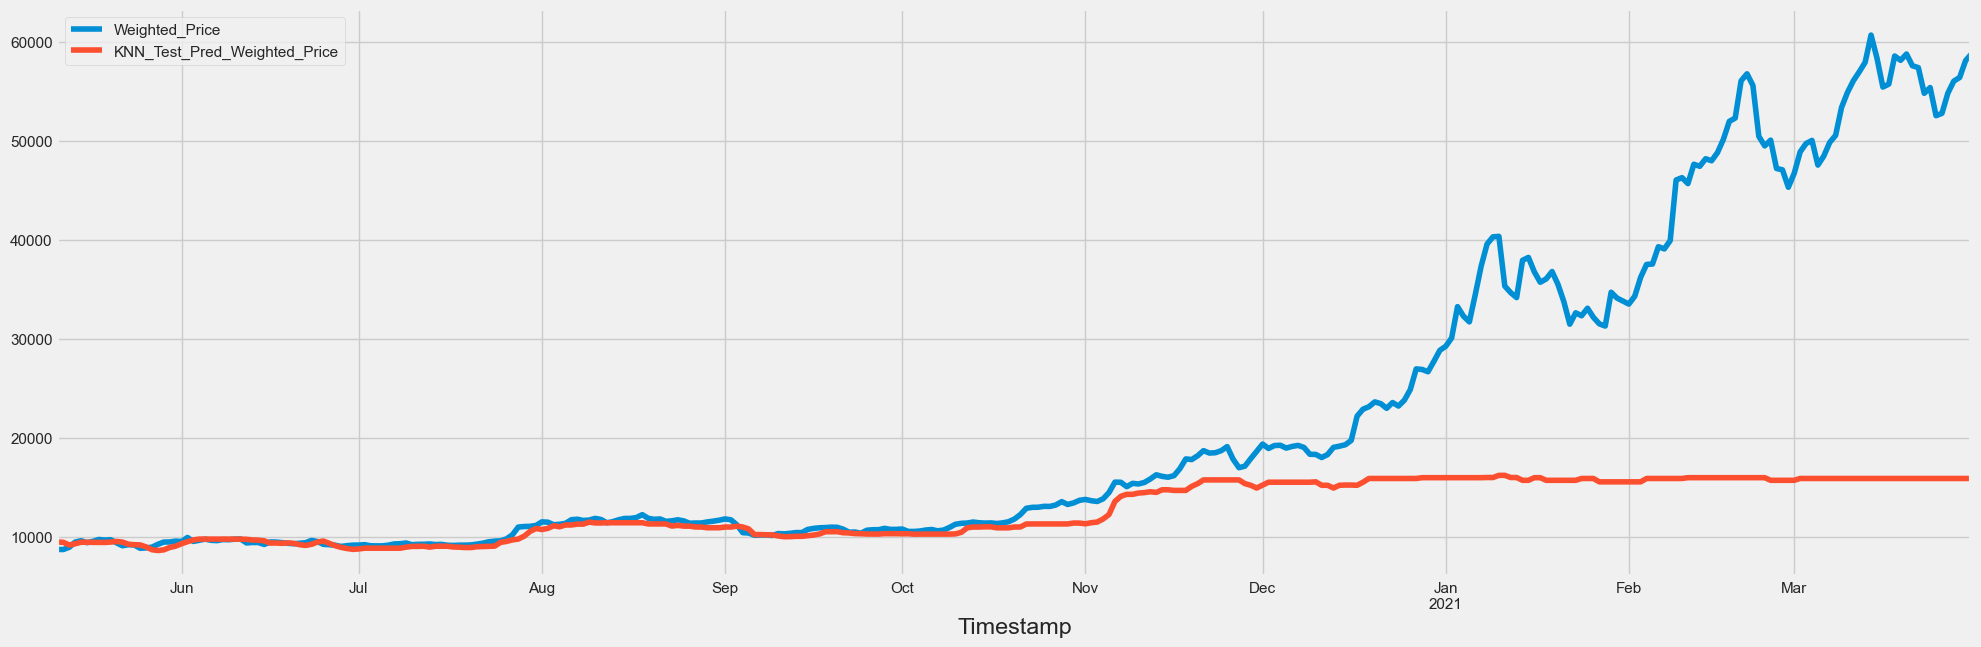

In [68]:
df_test['KNN_Test_Pred_Weighted_Price'] = knn.predict(X_test)

compare_df = pd.concat([df_train, df_test], sort=False)
df_test[['Weighted_Price','KNN_Test_Pred_Weighted_Price']].plot(figsize=(22, 7))

MAE & RMSE CALCULATION FOR TRAINIG & TESTING DATA SET (KNN)

In [69]:
train_mae_knn, train_rmse_knn = mae_rmse_score(df_train['Weighted_Price'],df_train['KNN_Train_Pred_Weighted_Price'])
test_mae_knn, test_rmse_knn = mae_rmse_score(df_test['Weighted_Price'],df_test['KNN_Test_Pred_Weighted_Price'])

print(f"Train MAE KNN : {train_mae_knn}")
print(f"Train RMSE KNN: {train_rmse_knn}")
print()
print(f"Test MAE KNN : {test_mae_knn}")
print(f"Test RMSE KNN: {test_rmse_knn}")

Train MAE KNN : 101.45
Train RMSE KNN: 272.84

Test MAE KNN : 9079.43
Test RMSE KNN: 16264.1


OVERALL AND EACH DATA MAPE SCORE (KNN)

In [70]:
overall_mape_knn = mape_score(df_test['Weighted_Price'], df_test['KNN_Test_Pred_Weighted_Price'])
compare_df['MAPE_KNN']=compare_df.apply(lambda x : mape_score(x["Weighted_Price"],x["KNN_Test_Pred_Weighted_Price"]), axis=1)

print("Overall MAPE score (KNN): ",overall_mape_knn)
print('\n---------------------------------\n')
compare_df['MAPE_KNN'].dropna()

Overall MAPE score (KNN):  23.33

---------------------------------



Timestamp
2020-05-11     8.57
2020-05-12     8.31
2020-05-13     2.50
2020-05-14     1.83
2020-05-15     1.55
              ...  
2021-03-27    71.00
2021-03-28    71.63
2021-03-29    71.82
2021-03-30    72.64
2021-03-31    72.96
Freq: D, Name: MAPE_KNN, Length: 325, dtype: float64

RF

In [71]:
rf =RandomForestRegressor(n_estimators =10, random_state= 0) 
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

DATA & PLOT (RF TRAINING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\3090114662.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

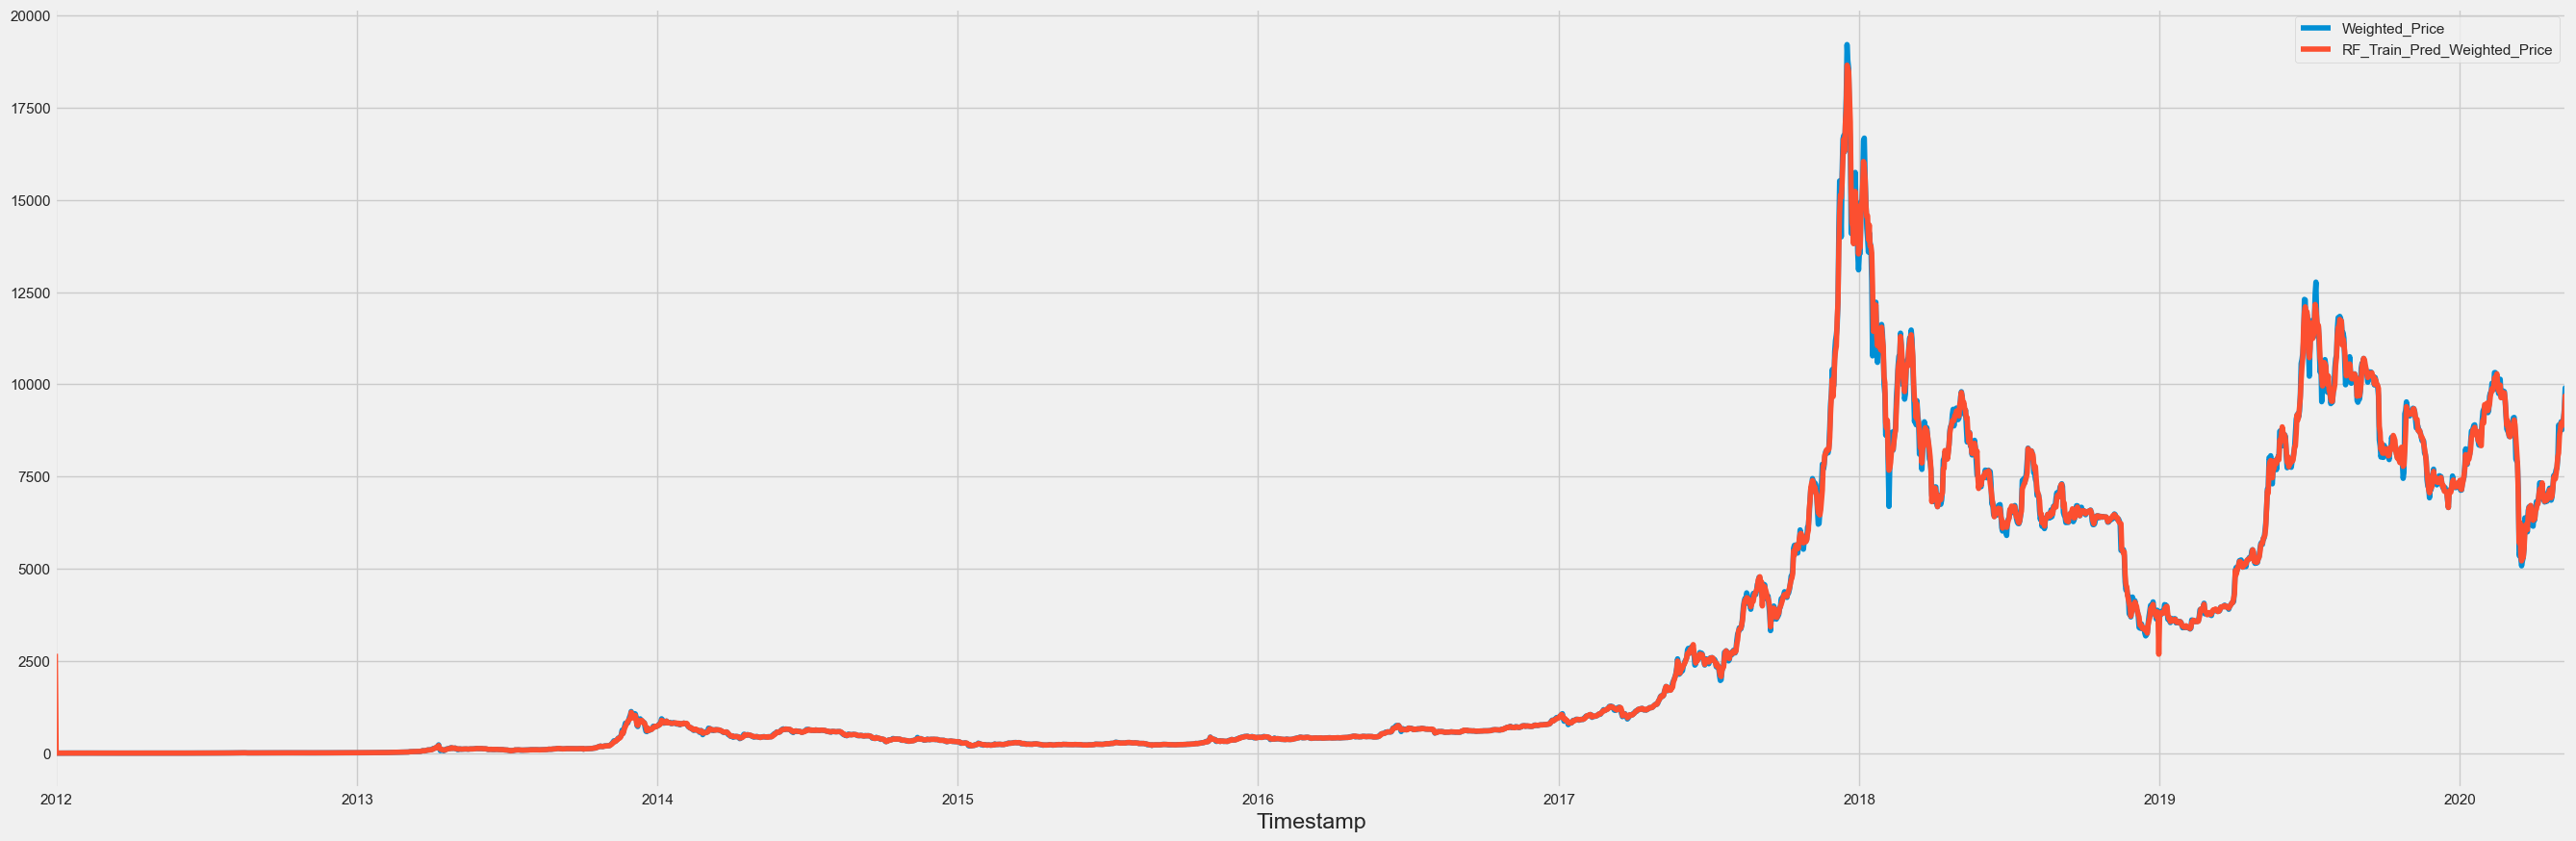

In [72]:
df_train['RF_Train_Pred_Weighted_Price'] = rf.predict(X_train)

df_train[['Weighted_Price','RF_Train_Pred_Weighted_Price']].plot(figsize=(30, 10))

DATA & PLOT (RF TESTING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\1748228571.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

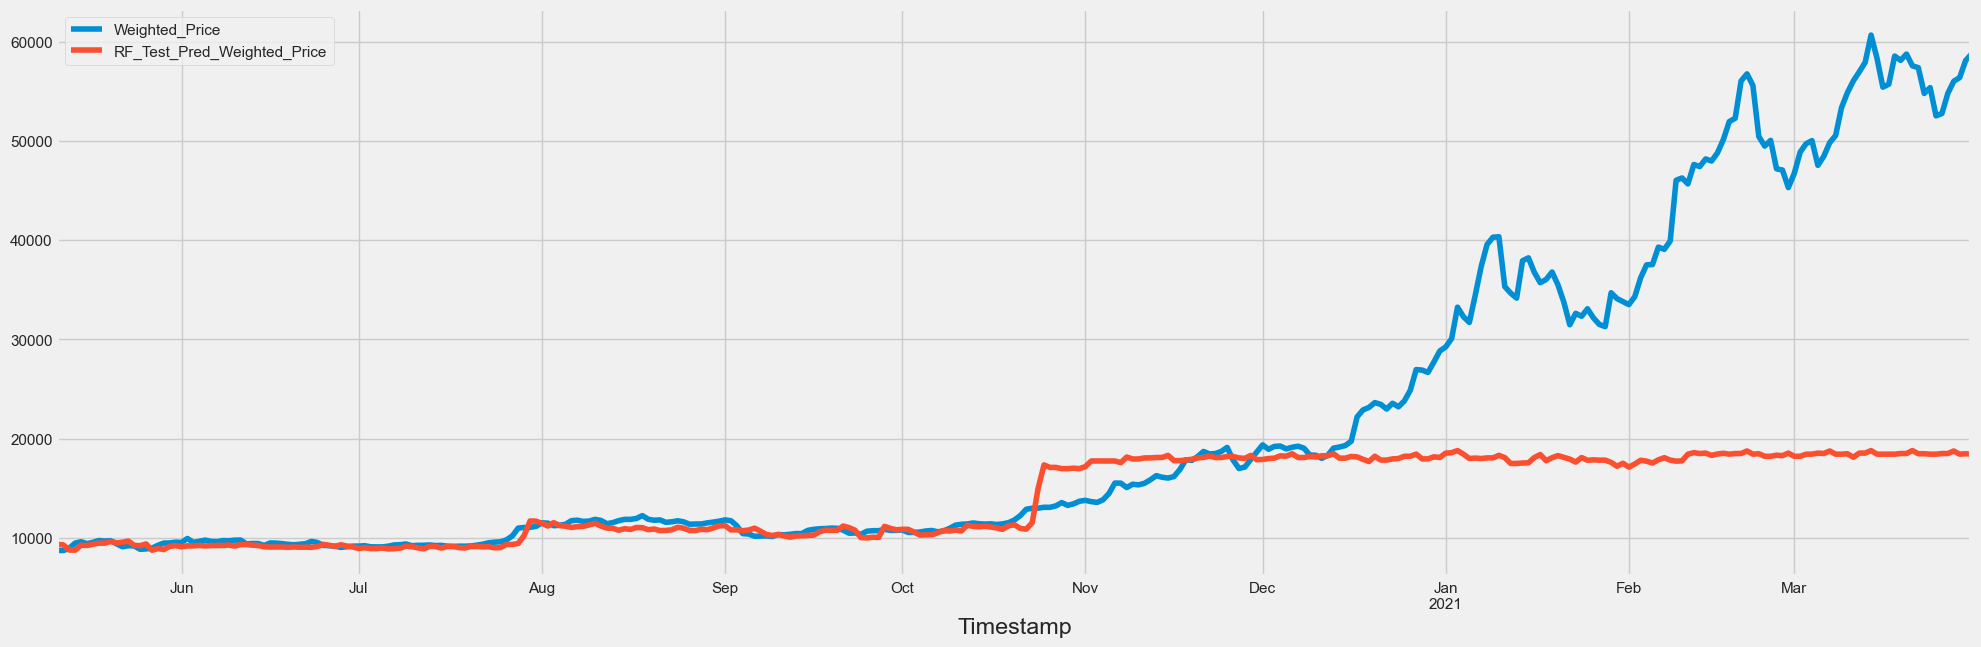

In [73]:
df_test['RF_Test_Pred_Weighted_Price'] = rf.predict(X_test)

compare_df = pd.concat([df_train, df_test], sort=False)
df_test[['Weighted_Price','RF_Test_Pred_Weighted_Price']].plot(figsize=(22, 7))

MAE & RMSE CALCULATION FOR TRAINIG & TESTING DATA SET (RF)

In [74]:
train_mae_rf, train_rmse_rf = mae_rmse_score(df_train['Weighted_Price'],df_train['RF_Train_Pred_Weighted_Price'])
test_mae_rf, test_rmse_rf = mae_rmse_score(df_test['Weighted_Price'],df_test['RF_Test_Pred_Weighted_Price'])

print(f"Train MAE RF : {train_mae_rf}")
print(f"Train RMSE RF: {train_rmse_rf}")
print()
print(f"Test MAE RF : {test_mae_rf}")
print(f"Test RMSE RF: {test_rmse_rf}")

Train MAE RF : 40.15
Train RMSE RF: 120.74

Test MAE RF : 8220.79
Test RMSE RF: 15008.32


OVERALL AND EACH DATA MAPE SCORE (RF)

In [75]:
overall_mape_rf = mape_score(df_test['Weighted_Price'], df_test['RF_Test_Pred_Weighted_Price'])
compare_df['MAPE_RF']=compare_df.apply(lambda x : mape_score(x["Weighted_Price"],x["RF_Test_Pred_Weighted_Price"]), axis=1)

print("Overall MAPE score (RF): ",overall_mape_rf)
print('\n---------------------------------\n')
compare_df['MAPE_RF'].dropna()

Overall MAPE score (RF):  21.11

---------------------------------



Timestamp
2020-05-11     7.19
2020-05-12     6.42
2020-05-13     2.02
2020-05-14     7.57
2020-05-15     3.64
              ...  
2021-03-27    66.25
2021-03-28    66.52
2021-03-29    67.32
2021-03-30    68.20
2021-03-31    68.64
Freq: D, Name: MAPE_RF, Length: 325, dtype: float64

LR

In [76]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

DATA & PLOT (LR TRAINING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\3430666291.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

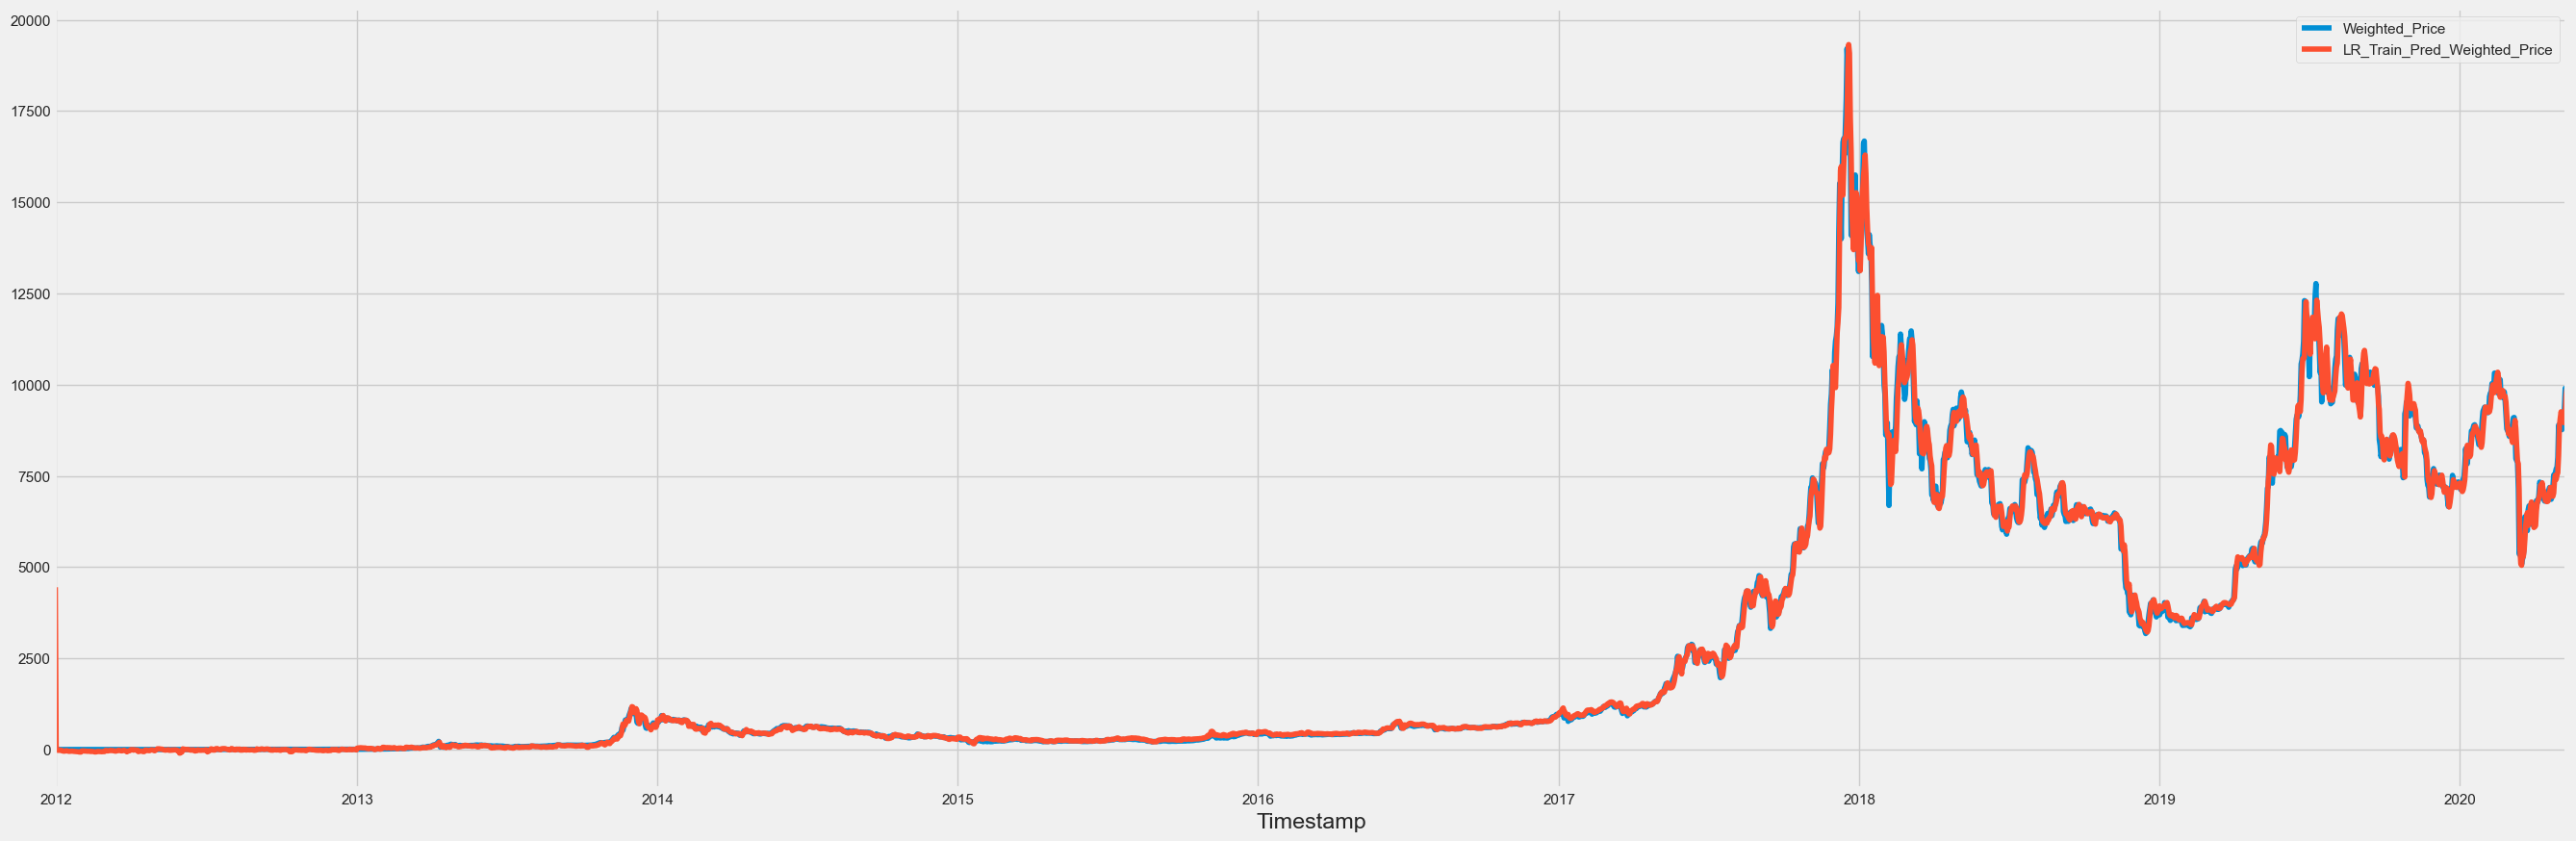

In [77]:
df_train['LR_Train_Pred_Weighted_Price'] = lr.predict(X_train)

df_train[['Weighted_Price','LR_Train_Pred_Weighted_Price']].plot(figsize=(30, 10))

DATA & PLOT (LR TESTING SET)

C:\Users\chaya\AppData\Local\Temp\ipykernel_6864\1988313708.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='Timestamp'>

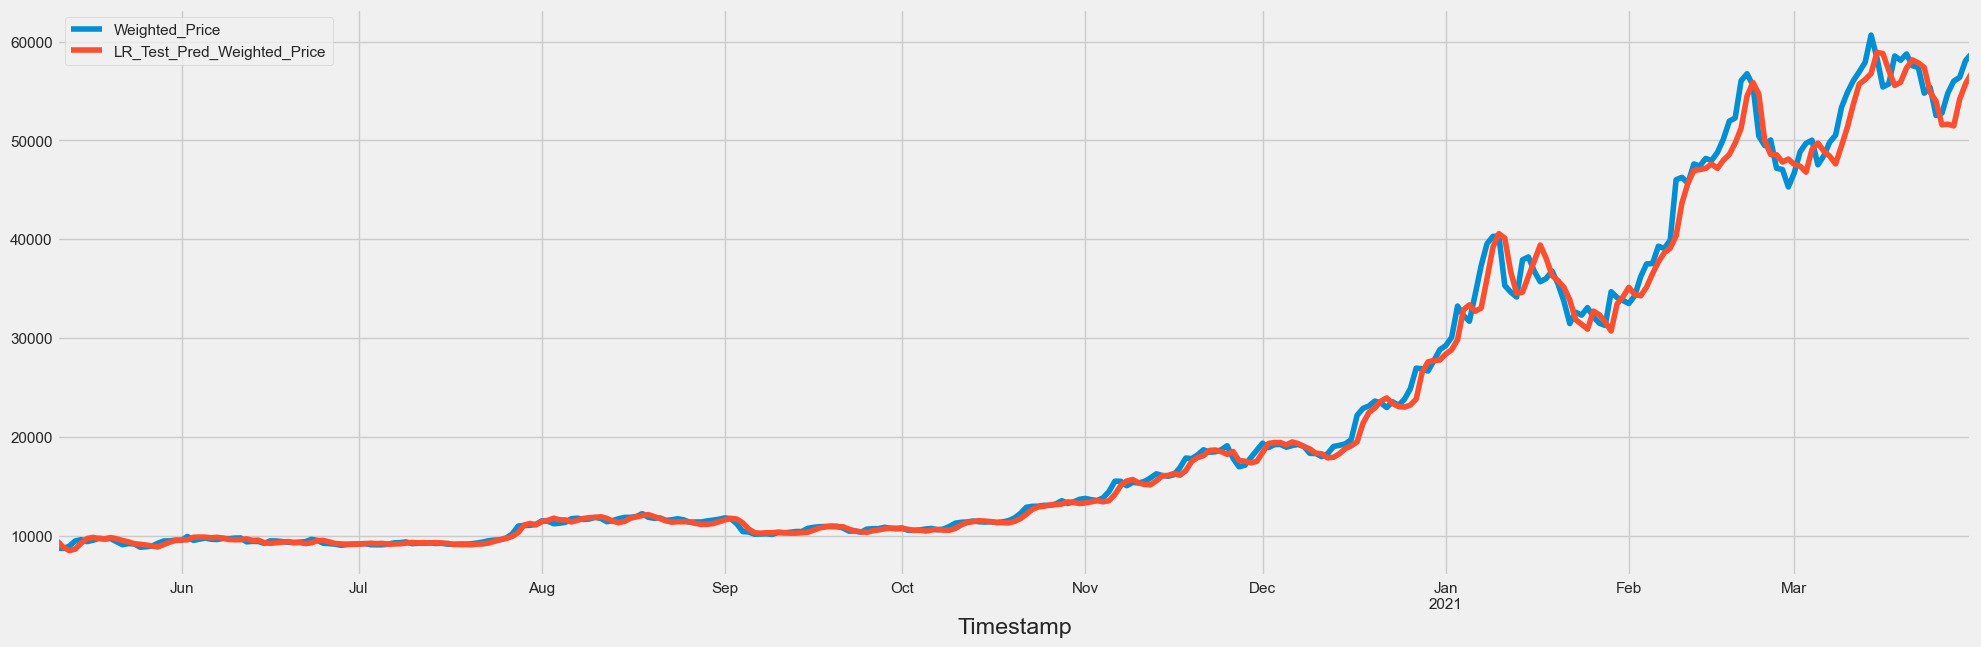

In [78]:
df_test['LR_Test_Pred_Weighted_Price'] = lr.predict(X_test)

compare_df = pd.concat([df_train, df_test], sort=False)
df_test[['Weighted_Price','LR_Test_Pred_Weighted_Price']].plot(figsize=(22, 7))

MAE & RMSE CALCULATION FOR TRAINIG & TESTING DATA SET (LR)

In [79]:
train_mae_lr, train_rmse_lr = mae_rmse_score(df_train['Weighted_Price'],df_train['LR_Train_Pred_Weighted_Price'])
test_mae_lr, test_rmse_lr = mae_rmse_score(df_test['Weighted_Price'],df_test['LR_Test_Pred_Weighted_Price'])

print(f"Train MAE LR : {train_mae_lr}")
print(f"Train RMSE LR: {train_rmse_lr}")
print()
print(f"Test MAE LR : {test_mae_lr}")
print(f"Test RMSE LR: {test_rmse_lr}")

Train MAE LR : 106.52
Train RMSE LR: 240.78

Test MAE LR : 711.76
Test RMSE LR: 1245.49


OVERALL AND EACH DATA MAPE SCORE (LR)

In [80]:
overall_mape_lr = mape_score(df_test['Weighted_Price'], df_test['LR_Test_Pred_Weighted_Price'])
compare_df['MAPE_LR']=compare_df.apply(lambda x : mape_score(x["Weighted_Price"],x["LR_Test_Pred_Weighted_Price"]), axis=1)

print("Overall MAPE score (LR): ",overall_mape_lr)
print('\n---------------------------------\n')
compare_df['MAPE_LR'].dropna()

Overall MAPE score (LR):  2.6

---------------------------------



Timestamp
2020-05-11    8.30
2020-05-12    1.19
2020-05-13    4.96
2020-05-14    8.72
2020-05-15    3.75
              ... 
2021-03-27    5.75
2021-03-28    8.10
2021-03-29    3.93
2021-03-30    4.04
2021-03-31    3.34
Freq: D, Name: MAPE_LR, Length: 325, dtype: float64

MAPE SCORE OF ALL MODEL

In [81]:
print("MAPE For XGBoost: ",overall_mape_xgb)
print("MAPE For Support Vector Regression: ",overall_mape_svr)
print("MAPE For K Nearest Neighbours: ",overall_mape_knn)
print("MAPE For Random Forest Regressor: ",overall_mape_rf)
print("MAPE For Linear Regression: ",overall_mape_lr)

MAPE For XGBoost:  22.78
MAPE For Support Vector Regression:  29.94
MAPE For K Nearest Neighbours:  23.33
MAPE For Random Forest Regressor:  21.11
MAPE For Linear Regression:  2.6


MAE & RMSE SCORE OF ALL MODEL

In [82]:
# Train
print(f"train MAE XGBOOST : {train_mae_xgboost}")
print(f"train RMSE XGBOOST: {train_rmse_xgboost}\n")
print(f"train MAE SVR: {train_mae_svr}")
print(f"train RMSE SVR: {train_rmse_svr}\n")
print(f"train MAE KNN: {train_mae_knn}")
print(f"train RMSE KNN: {train_rmse_knn}\n")
print(f"train MAE RF: {train_mae_rf}")
print(f"train RMSE RF: {train_rmse_rf}\n")
print(f"train MAE LR: {train_mae_lr}")
print(f"train RMSE LR: {train_rmse_lr}")

train MAE XGBOOST : 0.39
train RMSE XGBOOST: 0.51

train MAE SVR: 105.82
train RMSE SVR: 288.14

train MAE KNN: 101.45
train RMSE KNN: 272.84

train MAE RF: 40.15
train RMSE RF: 120.74

train MAE LR: 106.52
train RMSE LR: 240.78


In [83]:
# Test
print(f"test MAE XGBOOST : {test_mae_xgboost}")
print(f"test RMSE XGBOOST : {test_rmse_xgboost}\n")
print(f"test MAE SVR : {test_mae_svr}")
print(f"test RMSE SVR : {test_rmse_svr}\n")
print(f"test MAE KNN : {test_mae_knn}")
print(f"test RMSE KNN : {test_rmse_knn}\n")
print(f"test MAE RF : {test_mae_rf}")
print(f"test RMSE RF : {test_rmse_rf}\n")
print(f"test MAE LR: {test_mae_lr}")
print(f"test RMSE LR: {test_rmse_lr}")

test MAE XGBOOST : 8743.39
test RMSE XGBOOST : 15610.55

test MAE SVR : 11753.16
test RMSE SVR : 20626.99

test MAE KNN : 9079.43
test RMSE KNN : 16264.1

test MAE RF : 8220.79
test RMSE RF : 15008.32

test MAE LR: 711.76
test RMSE LR: 1245.49


# PLOT FOR ALL MODEL

<Axes: xlabel='Timestamp'>

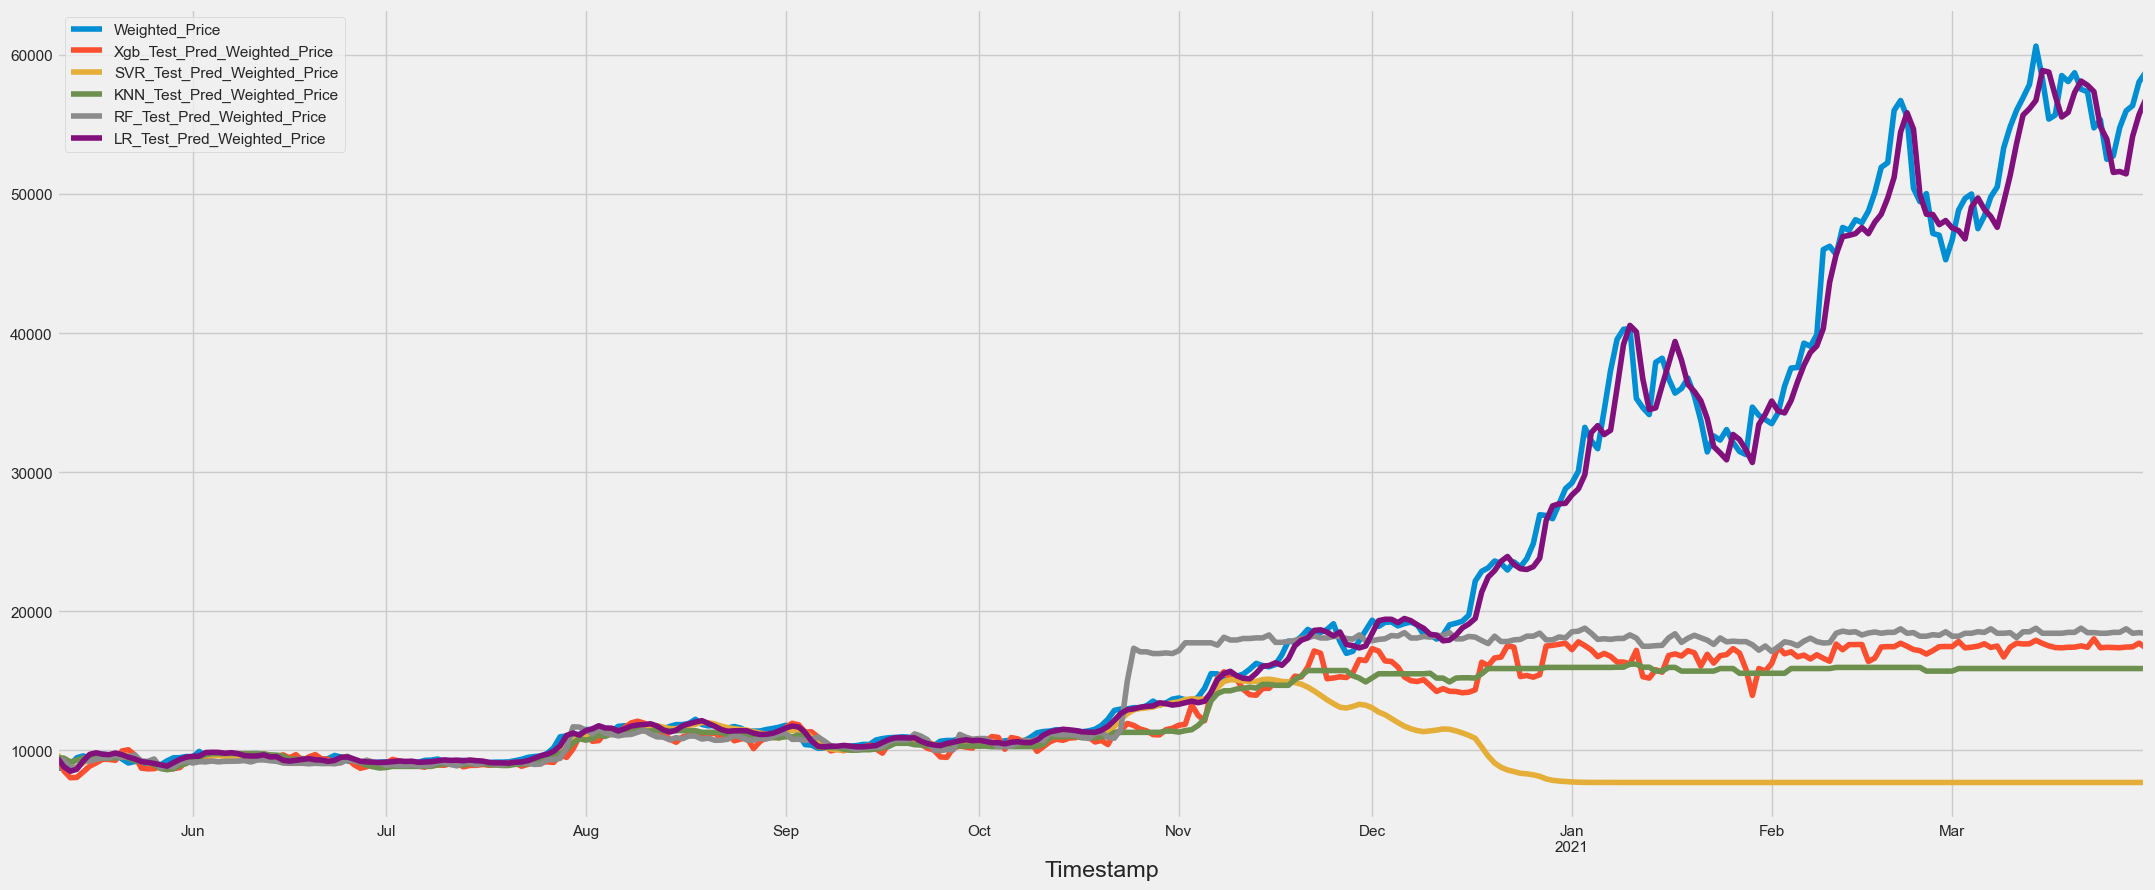

In [84]:
df_test[["Weighted_Price", "Xgb_Test_Pred_Weighted_Price", "SVR_Test_Pred_Weighted_Price", "KNN_Test_Pred_Weighted_Price","RF_Test_Pred_Weighted_Price","LR_Test_Pred_Weighted_Price"]].plot(figsize=(24,10))